# Data Processing

In [3]:
suppressMessages(library(ggplot2))
suppressMessages(library(reshape2))
suppressMessages(library(plotly))
suppressMessages(library(gplots))
suppressMessages(library(VennDiagram))
suppressMessages(library(RColorBrewer))
suppressMessages(library(stringr))
suppressMessages(library(ggpubr))
suppressMessages(library(ComplexHeatmap))
suppressMessages(library(circlize))
suppressMessages(library(pheatmap))
suppressMessages(library(gridExtra))
suppressMessages(library(ggplotify))
suppressMessages(library(patchwork))

In [4]:
options(stringsAsFactors = F)
#match cell.id to unique.cellid from PharmacoGx
matchToIDTable <- function(ids,tbl, column, returnColumn="unique.cellid") {
  sapply(ids, function(x) {
    myx <- grep(paste0("((///)|^)",Hmisc::escapeRegex(x),"((///)|$)"), tbl[,column])
    if(length(myx) > 1){
      stop("Something went wrong in curating ids, we have multiple matches")
    }
    if(length(myx) == 0){return(NA_character_)}
    return(tbl[myx, returnColumn])
  })
}

## <u>Determine biological replicates across datasets (gCSI, CCLE, GDSC)</u>

In [5]:
##read in current cell annotations
cell_all <- read.csv(file = "rnaseq_meta/cell_annotation_all.csv", na.strings=c("", " ", "NA"))

In [6]:
#read in gcsi cell annotations
gcsi <- read.csv(file = "rnaseq_meta/gcsi_rnaseq_meta.csv")
gcsi$cellid <- matchToIDTable(ids=gcsi$Cell_line , tbl = cell_all, column = "GNE.cellid", returnColumn = "unique.cellid")
rownames(gcsi) <- gcsi$alias

#read in ccle cell annotations
ccle <- read.csv(file = "rnaseq_meta/ccle_rnaseq_meta.csv")
ccle$cellid <- matchToIDTable(ids=ccle$Cell_Line , tbl = cell_all, column = "CCLE.cellid", returnColumn = "unique.cellid")
rownames(ccle) <- ccle$Run

#read in gdsc cell annotations
gdsc <- read.csv(file = "rnaseq_meta/gdsc_rnaseq_meta.txt", sep = "\t")
gdsc <- gdsc[which(!gdsc$Comment.SUBMITTED_FILE_NAME. == "15552_5.cram"),]
gdsc$cellid <- matchToIDTable(ids=gdsc$Source.Name, tbl = cell_all, column = "GDSC_rnaseq.cellid", returnColumn = "unique.cellid")
gdsc$files <- gsub(".cram","",gdsc$Comment.SUBMITTED_FILE_NAME.)
rownames(gdsc) <- gdsc$files

In [7]:
#filter metadata -> keep intersected cell lines only
intersected_rnacells <- Reduce(intersect, list(gdsc$cellid, ccle$cellid, gcsi$cellid))

gcsi <- gcsi[which(gcsi$cellid %in% intersected_rnacells),]
ccle <- ccle[which(ccle$cellid %in% intersected_rnacells),]
gdsc <- gdsc[which(gdsc$cellid %in% intersected_rnacells),]

print(intersected_rnacells) #replicates

 [1] "A-427"      "C2BBe1"     "CL-40"      "COLO 741"   "DU145"     
 [6] "HCC1187"    "HCC1806"    "HCT 116"    "HCT 15"     "HeLa"      
[11] "HT115"      "HT-29"      "HT-55"      "Karpas-620" "KNS-62"    
[16] "Ku812"      "LS180"      "MDA-MB-361" "MDST8"      "NCI-H510A" 
[21] "SNU-1"      "SNU-16"     "OVKATE"     "RKO"        "SET-2"     
[26] "SiHa"       "Rh30"       "SK-N-SH"    "SNU-C1"     "SR"        
[31] "SU-DHL-10"  "SU-DHL-5"   "SU-DHL-6"   "SUIT-2"     "SW1116"    
[36] "SW1463"     "SW1573"     "SW403"      "SW48"       "SW620"     
[41] "SW780"      "SW837"      "SW948"      "U266B1"     "UACC-812"  
[46] "WSU-DLCL2"  "YAPC"       "ZR-75-30"  


## <u>Summarize circRNA counts (summarizeCIRI, summarizeCIRC)</u>
### Function accomplishes the following:
- determines # of circRNA's (sum of junction reads) per biologial replicate in each dataset for each tool (CIRI2, CIRCexplorer2)
- outputs circRNA_ids (chr:start|end) across entire datasest. Note: CIRI2 circRNA_ids converted to 0-based start coordinate to match CIRCexplorer2.

NOTE: CIRI2 and CIRCexplorer2 annotate their circRNA's differently, resulting in slighly different circRNA coordinates for the same circRNA (1-based vs 0-based coordinates explained here: http://genome.ucsc.edu/blog/the-ucsc-genome-browser-coordinate-counting-systems/). 

*CIRI2* = start coordinate is "1-based" -> convert to 0-based to match CIRCexplorer2 by subtracting 1 from end of start coordinate (e.g. chr1:12714000**1**-127140001 -> chr1:12714000**0**-127140001)

*CIRCexplorer2* = start coordinate is "0-based"

#### CIRI2

In [8]:
summarizeCIRI <- function(dir_path){
    
  circRNA_ids <- c() #holds all circRNA_ids for dataset
  ciri_files <- list.files(path=dir_path,  pattern = "\\.tsv$", full.names = T) 
  circ_counts_df <- data.frame(matrix(ncol=2, nrow = length(ciri_files)))
  colnames(circ_counts_df) <- c("sample", "count")
  for (f in 1:length(ciri_files)) {
    sample <- read.table(file = ciri_files[f], 
                         sep = '\t', 
                         skip = 1,
                         header = FALSE)
    
    colnames(sample) <- c("circRNA_ID","chr","circRNA_start","circRNA_end","junction_reads", "SM_MS_SMS", "non_junction_reads", "junction_reads_ratio", "circRNA_type", "gene_id", "strand","junction_reads_ID")
    sample_name <- gsub("\\..*","", ciri_files[f])
    sample_name <- gsub(".*/","", sample_name)    
    sample <- sample[which(sample$circRNA_type=="exon"),] #keep only exonic circRNA's
    sample <- sample[which(sample$junction_reads >= 2),] #keep only circRNA's with >= 2 junction reads
    
    #convert coordinate from 1-based to 0-based to match CIRCexplorer2 coordinates
    sample$circRNA_start <- sample$circRNA_start - 1
    sample$circRNA_ID <- paste0(sample$chr, ":", sample$circRNA_start, "|", sample$circRNA_end)
      
    circRNA_ids <- c(sample$circRNA_ID, circRNA_ids)
    count <- sum(sample$junction_reads) #total number of junction reads per sample
    circ_counts_df[f,] <- c(sample_name,count)
  }
  xx <- list(circ_counts_df, circRNA_ids)
  names(xx)[1] <- "circ_counts_df"
  names(xx)[2] <- "circRNA_ids"
  return(xx)
} 

In [9]:
gcsi_ciri_summ <- summarizeCIRI(dir_path = "results/CIRI2/gCSI/result")
ccle_ciri_summ <- summarizeCIRI(dir_path = "results/CIRI2/CCLE/result")
gdsc_ciri_summ <- summarizeCIRI(dir_path = "results/CIRI2/GDSC/result")
hansen_ciri_summ <- summarizeCIRI(dir_path = "results/CIRI2/hansen/result") #both Ribo-zero + RNAse-R
hansen_ciri_matched_summ <- summarizeCIRI(dir_path = "results/CIRI2/hansen_match/result") #poly-A equivalent to Hansen data
gdsc_ribozero_ciri_summ <- summarizeCIRI(dir_path = "results/CIRI2/GDSC_Ribo/result") #GDSC Ribo-Zero samples (HCT-116, HeLa)

#save summarizeCIRI results
save(gcsi_ciri_summ, 
     ccle_ciri_summ, 
     gdsc_ciri_summ, 
     hansen_ciri_summ, 
     hansen_ciri_matched_summ, 
     gdsc_ribozero_ciri_summ, file="summarizeCIRI.RData")

In [10]:
#extract count df only
gcsi_ciri_counts <- gcsi_ciri_summ$circ_counts_df
ccle_ciri_counts <- ccle_ciri_summ$circ_counts_df
gdsc_ciri_counts <- gdsc_ciri_summ$circ_counts_df
hansen_ciri_counts <- hansen_ciri_summ$circ_counts_df
hansen_ciri_matched_counts <- hansen_ciri_matched_summ$circ_counts_df
gdsc_ribozero_ciri_counts <- gdsc_ribozero_ciri_summ$circ_counts_df

#clean up sample names (remove 'gcsi' & 'gdsc' strings from samples)
gcsi_ciri_counts$sample <- gsub("gcsi", "", gcsi_ciri_counts$sample)
gdsc_ciri_counts$sample <- gsub("gdsc", "", gdsc_ciri_counts$sample)

rownames(gcsi_ciri_counts) <- gcsi_ciri_counts$sample
rownames(ccle_ciri_counts) <- ccle_ciri_counts$sample
rownames(gdsc_ciri_counts) <- gdsc_ciri_counts$sample

gdsc_ribozero_ciri_counts$sample <- c("HCT 116","HeLa")
rownames(gdsc_ribozero_ciri_counts) <- gdsc_ribozero_ciri_counts$sample

#average SR technical replicate circRNA count in gCSI
gcsi_ciri_counts$cellid <- gcsi$cellid[match(rownames(gcsi_ciri_counts), rownames(gcsi))]
gcsi_SR_mean <- mean(as.numeric(gcsi_ciri_counts$count[which(gcsi_ciri_counts$cellid=="SR")]))
gcsi_ciri_counts[which(gcsi_ciri_counts$cellid=="SR"),][2,"count"] <- gcsi_SR_mean
gcsi_ciri_counts <- gcsi_ciri_counts[-which(gcsi_ciri_counts$sample=="587641"),]

#get unique.cellids for samples + order CCLE & GDSC, GDSC-Ribo unique.cellid by gCSI unique.cellid
ccle_ciri_counts$cellid <- ccle$cellid[match(rownames(ccle_ciri_counts), rownames(ccle))]
ccle_ciri_counts <- ccle_ciri_counts[match(gcsi_ciri_counts$cellid, ccle_ciri_counts$cellid),]

gdsc_ciri_counts$cellid <- gdsc$cellid[match(rownames(gdsc_ciri_counts), rownames(gdsc))]
gdsc_ciri_counts <- gdsc_ciri_counts[match(gcsi_ciri_counts$cellid, gdsc_ciri_counts$cellid),]

gdsc_ribozero_ciri_counts <- gdsc_ribozero_ciri_counts[match(gcsi_ciri_counts$cellid,rownames(gdsc_ribozero_ciri_counts)),]

In [29]:
#create combined dataframe of CIRI2 counts for each replicate across gCSI, CCLE, GDSC
ciri_combined <- data.frame("gcsi"=as.numeric(gcsi_ciri_counts$count), 
                            "ccle"=as.numeric(ccle_ciri_counts$count), 
                            "gdsc"=as.numeric(gdsc_ciri_counts$count),
                            "gdsc-ribo"=as.numeric(gdsc_ribozero_ciri_counts$count))

rownames(ciri_combined) <- gcsi_ciri_counts$cellid
colnames(ciri_combined) <- c("gCSI","CCLE","GDSC","GDSC-Ribo")

#### CIRCexplorer2

In [14]:
summarizeCIRCexplorer <- function(dir_path){
    
  circRNA_ids <- c() #holds all circRNA_ids for dataset
  circ_files <- list.files(path=dir_path,  pattern = ".txt", full.names = TRUE, recursive = TRUE)
  circ_counts_df <- data.frame(matrix(ncol=2, nrow = length(circ_files)))
  colnames(circ_counts_df) <- c("sample", "count")
  for (f in 1:length(circ_files)) {
    sample <- read.table(file = circ_files[f], 
                         sep = '\t',
                         header = FALSE)
    
    colnames(sample) <- c("chrom","start","end", "name","score","strand","thickStart","thickEnd","itemRgb","exonCount","exonSizes", "exonOffsets", "readNumber", "circType", "geneName", "isoformName", "index", "flankIntron")

    sample_name <- sub(".*/ *(.*?) *.txt.*", "\\1", circ_files[f])
    sample <- sample[which(sample$circType=="circRNA"),] #keep only exonic circRNA's
    sample <- sample[which(sample$readNumber >= 2),] #keep only circRNA's with junction reads >= 2
    
    sample$circRNA_ID <- paste0(sample$chrom,":",sample$start,"|",sample$end) #create circRNA_id using chr, start & end coordinates
    circRNA_ids <- c(sample$circRNA_ID, circRNA_ids)
    count <- sum(sample$readNumber) #total # of junction reads per sample
    circ_counts_df[f,] <- c(sample_name,count)
  }
  xx <- list(circ_counts_df, circRNA_ids)
  names(xx)[1] <- "circ_counts_df"
  names(xx)[2] <- "circRNA_ids"
  return(xx)
} 

In [15]:
gcsi_circ_summ <- summarizeCIRCexplorer(dir_path = "results/CIRCexplorer2/gCSI/unmapped_method/annotate")
ccle_circ_summ <- summarizeCIRCexplorer(dir_path = "results/CIRCexplorer2/CCLE/unmapped_method/annotate")
gdsc_circ_summ <- summarizeCIRCexplorer(dir_path = "results/CIRCexplorer2/GDSC/unmapped_method/annotate")
hansen_circ_summ <- summarizeCIRCexplorer(dir_path = "results/CIRCexplorer2/hansen/annotate") #both Ribo-zero + RNAse-R
hansen_circ_matched_summ <- summarizeCIRCexplorer(dir_path = "results/CIRCexplorer2/hansen_match/annotate") #poly-A equivalent to Hansen data
gdsc_ribozero_circ_summ <- summarizeCIRCexplorer(dir_path = "results/CIRCexplorer2/GDSC_Ribo/annotate") #GDSC Ribo-Zero samples (HCT-116, HeLa)

#save summarizeCIRC results
save(gcsi_circ_summ, 
     ccle_circ_summ, 
     gdsc_circ_summ, 
     hansen_circ_summ, 
     hansen_circ_matched_summ, 
     gdsc_ribozero_circ_summ, file="summarizeCIRC.RData")

In [16]:
#extract count df only
gcsi_circ_counts <- gcsi_circ_summ$circ_counts_df
ccle_circ_counts <- ccle_circ_summ$circ_counts_df
gdsc_circ_counts <- gdsc_circ_summ$circ_counts_df
hansen_circ_counts <- hansen_circ_summ$circ_counts_df
hansen_circ_matched_counts <- hansen_circ_matched_summ$circ_counts_df
gdsc_ribozero_circ_counts <- gdsc_ribozero_circ_summ$circ_counts_df

#clean up sample names (remove 'gcsi' & 'gdsc' strings from samples)
gcsi_circ_counts$sample <- sub(".*gcsi *(.*?) *_.*", "\\1", gcsi_circ_counts$sample)
rownames(gcsi_circ_counts) <- gcsi_circ_counts$sample

ccle_circ_counts$sample <- sub("* *(.*?) *_circular.*", "\\1", ccle_circ_counts$sample)
rownames(ccle_circ_counts) <- ccle_circ_counts$sample

gdsc_circ_counts$sample <- sub(".*gdsc *(.*?) *_circular.*", "\\1", gdsc_circ_counts$sample)
rownames(gdsc_circ_counts) <- gdsc_circ_counts$sample

gdsc_ribozero_circ_counts$sample <- c("HCT 116","HeLa")
rownames(gdsc_ribozero_circ_counts) <- gdsc_ribozero_circ_counts$sample

#average SR technical replicate circRNA count in gCSI
gcsi_circ_counts$cellid <- gcsi$cellid[match(rownames(gcsi_circ_counts), rownames(gcsi))]
gcsi_SR_mean <- mean(as.numeric(gcsi_circ_counts$count[which(gcsi_circ_counts$cellid=="SR")]))
gcsi_circ_counts[which(gcsi_circ_counts$cellid=="SR"),][2,"count"] <- gcsi_SR_mean
gcsi_circ_counts <- gcsi_circ_counts[-which(gcsi_circ_counts$sample=="587641"),]

#get unique.cellids for samples + order CCLE & GDSC & GDSC-ribo unique.cellid by gCSI unique.cellid
ccle_circ_counts$cellid <- ccle$cellid[match(rownames(ccle_circ_counts), rownames(ccle))]
ccle_circ_counts <- ccle_circ_counts[match(gcsi_circ_counts$cellid, ccle_circ_counts$cellid),]

gdsc_circ_counts$cellid <- gdsc$cellid[match(rownames(gdsc_circ_counts), rownames(gdsc))]
gdsc_circ_counts <- gdsc_circ_counts[match(gcsi_circ_counts$cellid, gdsc_circ_counts$cellid),]

gdsc_ribozero_circ_counts <- gdsc_ribozero_circ_counts[match(gcsi_circ_counts$cellid,rownames(gdsc_ribozero_circ_counts)),]

In [28]:
#create combined dataframe of CIRCexplorer counts for each replicate across gCSI, CCLE, GDSC
circ_combined <- data.frame("gcsi"=as.numeric(gcsi_circ_counts$count), 
                            "ccle"=as.numeric(ccle_circ_counts$count), 
                            "gdsc"=as.numeric(gdsc_circ_counts$count),
                            "gdsc-ribo"=as.numeric(gdsc_ribozero_circ_counts$count))
rownames(circ_combined) <- gcsi_circ_counts$cellid
colnames(circ_combined) <- c("gCSI","CCLE","GDSC","GDSC-Ribo")

## <u>Validate circRNA's with matched RNAse-R Hansen samples (filterCIRI, filterCIRC)</u>
### Function accomplishes the following:
- reports circRNA counts for circRNA's which have at least 1.5-fold enrichment in matching RNAse-R sample (polyA vs RNAse-R / Ribo-zero vs RNAse-R)

#### CIRI2

In [20]:
filterCIRI <- function(nonRNAseR_dir, RNAseR_dir, suff){
  #"*neg.tsv$" <- for ribominus
  #"\\.tsv$"<- for poly-A selected data
  ciri_files <- list.files(path=nonRNAseR_dir, pattern = suff, full.names = T)
  circ_counts_df <- data.frame(matrix(ncol=2, nrow = length(ciri_files)))
  colnames(circ_counts_df) <- c("sample", "count")
  for (f in 1:length(ciri_files)) {
    sample <- read.table(file = ciri_files[f], 
                         sep = '\t', 
                         skip = 1,
                         header = FALSE)
    
    sample_name <- gsub("\\..*","", ciri_files[f])
    sample_name <- gsub(".*/","", sample_name)
    match_name <- gsub("ccle|gcsi", "",ciri_files[f])
    match_name <- gsub("\\..*","", match_name)
    match_name <- gsub(".*/","", match_name)
    match_name <- gsub("neg","", match_name)
    
    hansen_match <- read.table(file = paste0(RNAseR_dir, match_name,"pos.tsv"), 
                               sep = '\t', 
                               skip = 1,
                               header = FALSE)
    
    colnames(sample) <- c("circRNA_ID","chr","circRNA_start","circRNA_end","junction_reads", "SM_MS_SMS", "non_junction_reads", "junction_reads_ratio", "circRNA_type", "gene_id", "strand","junction_reads_ID")
    colnames(hansen_match) <- c("circRNA_ID","chr","circRNA_start","circRNA_end","junction_reads", "SM_MS_SMS", "non_junction_reads", "junction_reads_ratio", "circRNA_type", "gene_id", "strand","junction_reads_ID")

    sample_match <- sample[which(sample$circRNA_type=="exon"),] #keep exonic circRNA's only
    sample_match <- sample_match[which(sample_match$junction_reads >= 2),] #keep only circRNA's with junction reads >= 2
    
    hansen_match <- hansen_match[which(hansen_match$circRNA_type=="exon"),] #keep exonic circRNA's only
    hansen_match <- hansen_match[which(hansen_match$junction_reads >= 2),]  #keep only circRNA's with junction reads >= 2 
    
    sample_match <- sample_match[which(sample_match$circRNA_ID %in% hansen_match$circRNA_ID),]
    hansen_match <- hansen_match[which(hansen_match$circRNA_ID %in% sample_match$circRNA_ID),]
    
    filtered <- sample_match[hansen_match$junction_reads/sample_match$junction_reads >= 1.5,] #keep only circRNA's with at least 1.5-fold enrichment in matching RNAse-R sample

    count <- sum(filtered$junction_reads) #total # of junction reads per sample
    circ_counts_df[f,] <- c(sample_name,count)
  }
  return(circ_counts_df)
} 


In [21]:
#validated circRNA's from 22Rv1 (CCLE), LNCaP(CCLE), PC3(CCLE/gCSI) using matched Hansen RNAse-R enriched samples
validated_polyA_ciri <- filterCIRI(nonRNAseR_dir = "results/CIRI2/hansen_match/result", 
                                RNAseR_dir = "results/CIRI2/hansen/result/",
                                suff = "\\.tsv$")

#validated circRNA's from 22Rv1, LNCaP, and PC3 Hansen Ribo-Zero samples using matched Hansen RNAse-R enriched samples
validated_RiboZero_ciri <- filterCIRI(nonRNAseR_dir = "results/CIRI2/hansen/result", 
                                       RNAseR_dir = "results/CIRI2/hansen/result/",
                                       suff = "*neg.tsv$")

#### CIRCexplorer2

In [24]:
filterCIRC <- function(nonRNAseR_dir, RNAseR_dir, suff){
  #"*neg*" <- for ribominus
  #"\\.txt$"<- for poly-A selected data
  circ_files <- list.files(path=nonRNAseR_dir,  pattern = suff, full.names = T, recursive = TRUE)
  circ_counts_df <- data.frame(matrix(ncol=2, nrow = length(circ_files)))
  colnames(circ_counts_df) <- c("sample", "count")
  for (f in 1:length(circ_files)) {
    sample <- read.table(file = circ_files[f], 
                         sep = '\t',
                         header = FALSE)
    
    sample_name <- gsub("_circularRNA_known.txt","", circ_files[f])
    sample_name <- gsub(".*/","", sample_name)
    match_name <- gsub("neg", "",sample_name)
    match_name <- gsub("ccle|gcsi", "",match_name)
    
    hansen_match <- read.table(file = paste0(RNAseR_dir, "/" ,match_name, "pos", "/", match_name,"pos", "_circularRNA_known.txt"),
                               sep = '\t',
                               header = FALSE)
    
    colnames(sample) <- c("chrom","start","end", "name","score","strand","thickStart","thickEnd","itemRgb","exonCount","exonSizes", "exonOffsets", "readNumber", "circType", "geneName", "isoformName", "index", "flankIntron")
    colnames(hansen_match) <- c("chrom","start","end", "name","score","strand","thickStart","thickEnd","itemRgb","exonCount","exonSizes", "exonOffsets", "readNumber", "circType", "geneName", "isoformName", "index", "flankIntron")
    
    sample_match <- sample[which(sample$circType=="circRNA"),]
    sample_match <- sample_match[which(sample_match$readNumber >= 2),] #keep only circRNA's with junction reads >= 2
    
    hansen_match <- hansen_match[which(hansen_match$circType=="circRNA"),]
    hansen_match <- hansen_match[which(hansen_match$readNumber >= 2),]
    
    sample_match$pos <- paste0(sample_match$chrom,sample_match$start,sample_match$end)
    hansen_match$pos <- paste0(hansen_match$chrom,hansen_match$start,hansen_match$end)
    
    sample_match <- sample_match[which(sample_match$pos %in% hansen_match$pos),]
    hansen_match <- hansen_match[which(hansen_match$pos %in% sample_match$pos),]
    hansen_match  <- hansen_match[match(sample_match$pos, hansen_match$pos),]
    
    filtered <- sample_match[hansen_match$readNumber/sample_match$readNumber >= 1.5,] #keep only circRNA's with at least 1.5-fold enrichment in matching RNAse-R sample
    
    count <- sum(filtered$readNumber)
    circ_counts_df[f,] <- c(sample_name,count)
  }
  return(circ_counts_df)
} 

In [25]:
#RNAse-R validated circRNA's from 22Rv1 (CCLE), LNCaP(CCLE), PC3(CCLE/gCSI) using matched Hansen RNAse-R enriched samples
validated_polyA_circ <- filterCIRC(nonRNAseR_dir = "results/CIRCexplorer2/hansen_match/annotate", 
                                       RNAseR_dir = "results/CIRCexplorer2/hansen/annotate",
                                       suff = "\\.txt$")


#RNAse-R validated circRNA's from 22Rv1, LNCaP, and PC3 Hansen Ribo-Zero samples using matched Hansen RNAse-R enriched samples
validated_RiboZero_circ <- filterCIRC(nonRNAseR_dir = "results/CIRCexplorer2/hansen/annotate", 
                                       RNAseR_dir = "results/CIRCexplorer2/hansen/annotate",
                                       suff = "*neg*")

## <u>Create circRNA's expression matrix for correlation plot (summarizeCIRIMatrix, summarizeCIRCMatrix)</u>
### Function accomplishes the following:
- Creates expression matrix from all unique circRNA-ids across all datasets

#### CIRI2

In [130]:
#import summarizeCIRI results to obtain all unique circRNA_ID's to create circRNA count matrix
load("summarizeCIRI.RData")
unique_ids <- unique(c(gcsi_ciri_summ$circRNA_ids, 
                       ccle_ciri_summ$circRNA_ids, 
                       gdsc_ciri_summ$circRNA_ids, 
                       hansen_ciri_summ$circRNA_ids, 
                       hansen_ciri_matched_summ$circRNA_ids, 
                       gdsc_ribozero_ciri_summ$circRNA_ids))

In [148]:
summarizeCIRIMatrix <- function(dir_path, unique_circ_ids, RNAseR_dir=FALSE, suff=FALSE){
  #if RNAseR matched samples provided
  if (!isFALSE(RNAseR_dir)){
    #"*neg.tsv$" <- for ribominus
    #"\\.tsv$"<- for poly-A selected data
    ciri_files <- list.files(path=dir_path, pattern = suff, full.names = T)
    circid_matrix <- data.frame(matrix(ncol=length(ciri_files), nrow = length(unique_circ_ids)))
    rownames(circid_matrix) <- unique_circ_ids
    
    for (f in 1:length(ciri_files)) {
    sample <- read.table(file = ciri_files[f], 
                         sep = '\t', 
                         skip = 1,
                         header = FALSE)
    
    sample_name <- gsub("\\..*","", ciri_files[f])
    sample_name <- gsub(".*/","", sample_name)
    match_name <- gsub("ccle|gcsi", "",ciri_files[f])
    match_name <- gsub("\\..*","", match_name)
    match_name <- gsub(".*/","", match_name)
    match_name <- gsub("neg","", match_name)
    
    RNAseR_match <- read.table(file = paste0(RNAseR_dir, match_name,"pos.tsv"), 
                               sep = '\t', 
                               skip = 1,
                               header = FALSE)
    
    colnames(sample) <- c("circRNA_ID","chr","circRNA_start","circRNA_end","junction_reads", "SM_MS_SMS", "non_junction_reads", "junction_reads_ratio", "circRNA_type", "gene_id", "strand","junction_reads_ID")
    colnames(RNAseR_match) <- c("circRNA_ID","chr","circRNA_start","circRNA_end","junction_reads", "SM_MS_SMS", "non_junction_reads", "junction_reads_ratio", "circRNA_type", "gene_id", "strand","junction_reads_ID")
    
    #convert coordinate from 1-based to 0-based to match CIRCexplorer2 coordinates
    sample$circRNA_start <- sample$circRNA_start - 1
    sample$circRNA_ID <- paste0(sample$chr, ":", sample$circRNA_start, "|", sample$circRNA_end)
        
    sample_match <- sample[which(sample$circRNA_type=="exon"),] #keep exonic circRNA's only
    sample_match <- sample_match[which(sample_match$junction_reads >= 2),] #keep only circRNA's with junction reads >= 2
    
    RNAseR_match <- RNAseR_match[which(RNAseR_match$circRNA_type=="exon"),] #keep exonic circRNA's only
    RNAseR_match <- RNAseR_match[which(RNAseR_match$junction_reads >= 2),]  #keep only circRNA's with junction reads >= 2 
    
    sample_match <- sample_match[which(sample_match$circRNA_ID %in% RNAseR_match$circRNA_ID),]
    RNAseR_match <- RNAseR_match[which(RNAseR_match$circRNA_ID %in% sample_match$circRNA_ID),]
    
    sample <- sample_match[RNAseR_match$junction_reads/sample_match$junction_reads >= 1.5,] #keep only circRNA's with at least 1.5-fold enrichment in matching RNAse-R sample
    
    #group junction reads by circRNA_ID
    circ_reads <- sample %>% 
      group_by(circRNA_ID) %>% 
      summarise(junction_reads = sum(junction_reads))
    
    circ_reads <- as.data.frame(circ_reads)
    rownames(circ_reads) <- circ_reads$circRNA_ID
    
    #add sample to circRNA_ID count matrix
    circid_matrix[rownames(circ_reads), f] <- circ_reads$junction_reads
    names(circid_matrix)[f] <- sample_name
    
  }
    
  } else {
    
  ciri_files <- list.files(path=dir_path,  pattern = "\\.tsv$", full.names = T)
  circid_matrix <- data.frame(matrix(ncol=length(ciri_files), nrow = length(unique_circ_ids)))
  rownames(circid_matrix) <- unique_circ_ids
  
  for (f in 1:length(ciri_files)) {
    sample <- read.table(file = ciri_files[f], 
                         sep = '\t', 
                         skip = 1,
                         header = FALSE)
    
    colnames(sample) <- c("circRNA_ID","chr","circRNA_start","circRNA_end","junction_reads", "SM_MS_SMS", "non_junction_reads", "junction_reads_ratio", "circRNA_type", "gene_id", "strand","junction_reads_ID")
    
    #convert coordinate from 1-based to 0-based to match CIRCexplorer2 coordinates
    sample$circRNA_start <- sample$circRNA_start - 1
    sample$circRNA_ID <- paste0(sample$chr, ":", sample$circRNA_start, "|", sample$circRNA_end)
      
    sample_name <- gsub("\\..*","", ciri_files[f])
    sample_name <- gsub(".*/","", sample_name)
    sample <- sample[which(sample$circRNA_type=="exon"),]
    sample <- sample[which(sample$junction_reads >= 2),]
    
   #group junction reads by circRNA_ID
    circ_reads <- sample %>% 
      group_by(circRNA_ID) %>% 
      summarise(junction_reads = sum(junction_reads))
    
    circ_reads <- as.data.frame(circ_reads)
    rownames(circ_reads) <- circ_reads$circRNA_ID
    
    #add sample to circRNA_ID count matrix
    circid_matrix[rownames(circ_reads), f] <- circ_reads$junction_reads
    names(circid_matrix)[f] <- sample_name
    
      }
    }
  #circid_matrix <- circid_matrix[rowSums(is.na(circid_matrix)) != ncol(circid_matrix), ]#remove rows that have NO exp (NA) for any sample
  circid_matrix[is.na(circid_matrix)] <- 0
  return(circid_matrix)
  
} 

In [149]:
gcsi_ciri_matrix <- summarizeCIRIMatrix(dir_path = "results/CIRI2/gCSI/result", unique_circ_ids = unique_ids)
ccle_ciri_matrix <- summarizeCIRIMatrix(dir_path = "results/CIRI2/CCLE/result", unique_circ_ids = unique_ids)
gdsc_ciri_matrix <- summarizeCIRIMatrix(dir_path = "results/CIRI2/GDSC/result", unique_circ_ids = unique_ids)

#hansen ribozero with hansen RNAseR validaton
hansen_ciri_ribozero_matrix <- summarizeCIRIMatrix(dir_path = "results/CIRI2/hansen/result", 
                                                   unique_circ_ids = unique_ids, 
                                                   suff = "*neg.tsv$", 
                                                   RNAseR_dir = "results/CIRI2/hansen/result/")


#cell line polyA with hansen RNAseR validaton
hansen_ciri_polyA_matrix <- summarizeCIRIMatrix(dir_path = "results/CIRI2/hansen_match/result", 
                                                   unique_circ_ids = unique_ids, 
                                                   suff = "\\.tsv$", 
                                                   RNAseR_dir = "results/CIRI2/hansen/result/")

gdsc_ribozero_ciri_matrix <- summarizeCIRIMatrix(dir_path = "results/CIRI2/GDSC_Ribo/result", unique_circ_ids = unique_ids)


save(gcsi_ciri_matrix, 
     ccle_ciri_matrix, 
     gdsc_ciri_matrix, 
     hansen_ciri_ribozero_matrix, 
     hansen_ciri_polyA_matrix, 
     gdsc_ribozero_ciri_matrix, file= "CIRI2/ciri_circ_matrix.RData")

#because there are genes with no circRNA exp (0), we need to log2 normalize + 1 for each gene
gcsi_ciri_matrix_norm <- log2(gcsi_ciri_matrix + 1)
ccle_ciri_matrix_norm <- log2(ccle_ciri_matrix + 1)
gdsc_ciri_matrix_norm <- log2(gdsc_ciri_matrix + 1)
hansen_ciri_ribozero_matrix_norm <- log2(hansen_ciri_ribozero_matrix + 1)
hansen_ciri_polyA_matrix_norm <- log2(hansen_ciri_polyA_matrix + 1)
gdsc_ribozero_ciri_matrix_norm <- log2(gdsc_ribozero_ciri_matrix + 1)

#use unique.cellids for column names of gene matrix & keep same column name order as gCSI
colnames(gcsi_ciri_matrix_norm) <- gsub("gcsi","", colnames(gcsi_ciri_matrix_norm))
colnames(gcsi_ciri_matrix_norm) <- gcsi$cellid[match(colnames(gcsi_ciri_matrix_norm), rownames(gcsi))]

colnames(gdsc_ciri_matrix_norm) <- gsub("gdsc","", colnames(gdsc_ciri_matrix_norm))
colnames(gdsc_ciri_matrix_norm) <- gdsc$cellid[match(colnames(gdsc_ciri_matrix_norm), rownames(gdsc))]
gdsc_ciri_matrix_norm <- gdsc_ciri_matrix_norm[names(gcsi_ciri_matrix_norm)]

colnames(ccle_ciri_matrix_norm) <- ccle$cellid[match(colnames(ccle_ciri_matrix_norm), rownames(ccle))]

#get mean of SR technical replicate in gCSI
gcsi_mean_sr <- rowMeans(gcsi_ciri_matrix_norm[which(colnames(gcsi_ciri_matrix_norm)=="SR")], na.rm=TRUE)
gcsi_ciri_matrix_norm[,which(colnames(gcsi_ciri_matrix_norm)=="SR")] <- NULL
gcsi_ciri_matrix_norm$SR <- gcsi_mean_sr


ccle_ciri_matrix_norm <- ccle_ciri_matrix_norm[names(gcsi_ciri_matrix_norm)]

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `

In [139]:
ncol(ccle_ciri_matrix_norm)

[1] 48

#### CIRCexplorer2

In [58]:
#import summarizeCIRI results to obtain all unique circRNA_ID's to create circRNA count matrix
load("summarizeCIRC.RData")
unique_ids <- unique(c(gcsi_circ_summ$circRNA_ids, 
                       ccle_circ_summ$circRNA_ids, 
                       gdsc_circ_summ$circRNA_ids, 
                       hansen_circ_summ$circRNA_ids, 
                       hansen_circ_matched_summ$circRNA_ids, 
                       gdsc_ribozero_circ_summ$circRNA_ids))

In [124]:
summarizeCIRCMatrix <- function(dir_path, unique_circ_ids, RNAseR_dir=FALSE, suff=FALSE){
    
  #if RNAseR matched samples provided
  if (!isFALSE(RNAseR_dir)){
    #"*neg*" <- for ribominus
    #"\\.txt$"<- for poly-A selected data
    circ_files <- list.files(path=dir_path,  pattern = suff, full.names = T, recursive = TRUE)
    circid_matrix <- data.frame(matrix(ncol=length(circ_files), nrow = length(unique_circ_ids)))
    rownames(circid_matrix) <- unique_circ_ids
    
      for (f in 1:length(circ_files)) {
        sample <- read.table(file = circ_files[f], 
                         sep = '\t',
                         header = FALSE)
    
        sample_name <- gsub("_circularRNA_known.txt","", circ_files[f])
        sample_name <- gsub(".*/","", sample_name)
        match_name <- gsub("neg", "",sample_name)
        match_name <- gsub("ccle|gcsi", "",match_name)
    
        RNAseR_match <- read.table(file = paste0(RNAseR_dir, "/" ,match_name, "pos", "/", match_name,"pos", "_circularRNA_known.txt"),
                               sep = '\t',
                               header = FALSE)
    
        colnames(sample) <- c("chrom","start","end", "name","score","strand","thickStart","thickEnd","itemRgb","exonCount","exonSizes", "exonOffsets", "readNumber", "circType", "geneName", "isoformName", "index", "flankIntron")
        colnames(RNAseR_match) <- c("chrom","start","end", "name","score","strand","thickStart","thickEnd","itemRgb","exonCount","exonSizes", "exonOffsets", "readNumber", "circType", "geneName", "isoformName", "index", "flankIntron")
    
        sample_match <- sample[which(sample$circType=="circRNA"),]
        sample_match <- sample_match[which(sample_match$readNumber >= 2),] #keep only circRNA's with junction reads >= 2
    
        RNAseR_match <- RNAseR_match[which(RNAseR_match$circType=="circRNA"),]
        RNAseR_match <- RNAseR_match[which(RNAseR_match$readNumber >= 2),]
        
        #create circRNA ID
        sample_match$circRNA_ID <- paste0(sample_match$chrom,":",sample_match$start,"|",sample_match$end)
        RNAseR_match$circRNA_ID <- paste0(RNAseR_match$chrom,":",RNAseR_match$start,"|",RNAseR_match$end)
    
        sample_match <- sample_match[which(sample_match$circRNA_ID %in% RNAseR_match$circRNA_ID),]
        RNAseR_match <- RNAseR_match[which(RNAseR_match$circRNA_ID %in% sample_match$circRNA_ID),]
        RNAseR_match  <- RNAseR_match[match(sample_match$circRNA_ID, RNAseR_match$circRNA_ID),]
          
        sample <- sample_match[RNAseR_match$readNumber/sample_match$readNumber >= 1.5,] #keep only circRNA's with at least 1.5-fold enrichment in matching RNAse-R sample
    
        #group junction reads by circRNA_ID
        circ_reads <- sample %>% 
        group_by(circRNA_ID) %>% 
        summarise(readNumber = sum(readNumber))
    
    
        circ_reads <- as.data.frame(circ_reads)
        rownames(circ_reads) <- circ_reads$circRNA_ID
    
        #add sample to circRNA_ID count matrix
        circid_matrix[rownames(circ_reads), f] <- circ_reads$readNumber
        names(circid_matrix)[f] <- sample_name
      }
      
  } else {
  
  circ_files <- list.files(path=dir_path,  pattern = ".txt", full.names = T, recursive = TRUE)
  circid_matrix <- data.frame(matrix(ncol=length(circ_files), nrow = length(unique_circ_ids)))
  rownames(circid_matrix) <- unique_circ_ids
  
  for (f in 1:length(circ_files)) {
    sample <- read.table(file = circ_files[f], 
                         sep = '\t', 
                         header = FALSE)
    
    colnames(sample) <- c("chrom","start","end", "name","score","strand","thickStart","thickEnd","itemRgb","exonCount","exonSizes", "exonOffsets", "readNumber", "circType", "geneName", "isoformName", "index", "flankIntron")
    sample_name <- sub(".*/ *(.*?) *.txt.*", "\\1", circ_files[f])
    sample_name <- gsub("_circularRNA_known", "", sample_name)
    sample <- sample[which(sample$circType=="circRNA"),]
    sample <- sample[which(sample$readNumber >= 2),]
    
    
    #create circRNA position ID, since not given, only in CIRI2 is it given automatically
    sample$circRNA_ID <- paste0(sample$chrom,":",sample$start,"|",sample$end)
    
    #group junction reads by circRNA_ID
    circ_reads <- sample %>% 
      group_by(circRNA_ID) %>% 
      summarise(readNumber = sum(readNumber))
    
    
    circ_reads <- as.data.frame(circ_reads)
    rownames(circ_reads) <- circ_reads$circRNA_ID
    
    #add sample to circRNA_ID count matrix
    circid_matrix[rownames(circ_reads), f] <- circ_reads$readNumber
    names(circid_matrix)[f] <- sample_name
    
    
      }
    }
  #circid_matrix <- circid_matrix[rowSums(is.na(circid_matrix)) != ncol(circid_matrix), ]#remove rows that have NO exp (NA) for any sample
  circid_matrix[is.na(circid_matrix)] <- 0
  return(circid_matrix)
} 

In [140]:
gcsi_circ_matrix <- summarizeCIRCMatrix(dir_path = "results/CIRCexplorer2/gCSI/unmapped_method/annotate", unique_circ_ids = unique_ids)
ccle_circ_matrix <- summarizeCIRCMatrix(dir_path = "results/CIRCexplorer2/CCLE/unmapped_method/annotate", unique_circ_ids = unique_ids)
gdsc_circ_matrix <- summarizeCIRCMatrix(dir_path = "results/CIRCexplorer2/GDSC/unmapped_method/annotate", unique_circ_ids = unique_ids)


#hansen ribozero with hansen RNAseR validaton
hansen_circ_ribozero_matrix <- summarizeCIRCMatrix(dir_path = "results/CIRCexplorer2/hansen/annotate", 
                                                   unique_circ_ids = unique_ids, 
                                                   suff = "*neg*", 
                                                   RNAseR_dir = "results/CIRCexplorer2/hansen/annotate")


#cell line polyA with hansen RNAseR validaton
hansen_circ_polyA_matrix <- summarizeCIRCMatrix(dir_path = "results/CIRCexplorer2/hansen_match/annotate", 
                                                   unique_circ_ids = unique_ids, 
                                                   suff = "\\.txt$", 
                                                   RNAseR_dir = "results/CIRCexplorer2/hansen/annotate/")


gdsc_ribozero_circ_matrix <- summarizeCIRCMatrix(dir_path = "results/CIRCexplorer2/GDSC_Ribo/annotate", unique_circ_ids = unique_ids)



save(gcsi_circ_matrix, 
     ccle_circ_matrix, 
     gdsc_circ_matrix, 
     hansen_circ_ribozero_matrix,
     hansen_circ_polyA_matrix,
     gdsc_ribozero_circ_matrix,
     file = "CIRCexplorer2/circexplorer_circ_matrix.RData")

#Because there are genes with no circRNA exp (0), we need to log2 normalize + 1 for each gene
gcsi_circ_matrix_norm <- log2(gcsi_circ_matrix + 1)
ccle_circ_matrix_norm <- log2(ccle_circ_matrix + 1)
gdsc_circ_matrix_norm <- log2(gdsc_circ_matrix + 1)
hansen_circ_ribozero_matrix_norm <- log2(hansen_circ_ribozero_matrix + 1)
hansen_circ_polyA_matrix_norm <- log2(hansen_circ_polyA_matrix + 1)
gdsc_ribozero_circ_matrix_norm <- log2(gdsc_ribozero_circ_matrix + 1)

#use unique.cellids for column names of gene matrix & keep same column name order as gCSI
colnames(gcsi_circ_matrix_norm) <- gsub("gcsi","", colnames(gcsi_circ_matrix_norm))
colnames(gcsi_circ_matrix_norm) <- gcsi$cellid[match(colnames(gcsi_circ_matrix_norm), rownames(gcsi))]

colnames(gdsc_circ_matrix_norm) <- gsub("gdsc","", colnames(gdsc_circ_matrix_norm))
colnames(gdsc_circ_matrix_norm) <- gdsc$cellid[match(colnames(gdsc_circ_matrix_norm), rownames(gdsc))]
gdsc_circ_matrix_norm <- gdsc_circ_matrix_norm[names(gcsi_circ_matrix_norm)]

colnames(ccle_circ_matrix_norm) <- ccle$cellid[match(colnames(ccle_circ_matrix_norm), rownames(ccle))]
ccle_circ_matrix_norm <- ccle_circ_matrix_norm[names(gcsi_circ_matrix_norm)]

#get mean of SR technical replicate in gCSI
gcsi_mean_sr <- rowMeans(gcsi_circ_matrix_norm[which(colnames(gcsi_circ_matrix_norm)=="SR")], na.rm=TRUE)
gcsi_circ_matrix_norm[,which(colnames(gcsi_circ_matrix_norm)=="SR")] <- NULL
gcsi_circ_matrix_norm$SR <- gcsi_mean_sr

ccle_circ_matrix_norm <- ccle_circ_matrix_norm[names(gcsi_circ_matrix_norm)]

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `

# Plots

## <u>circRNA read count distribution</u>

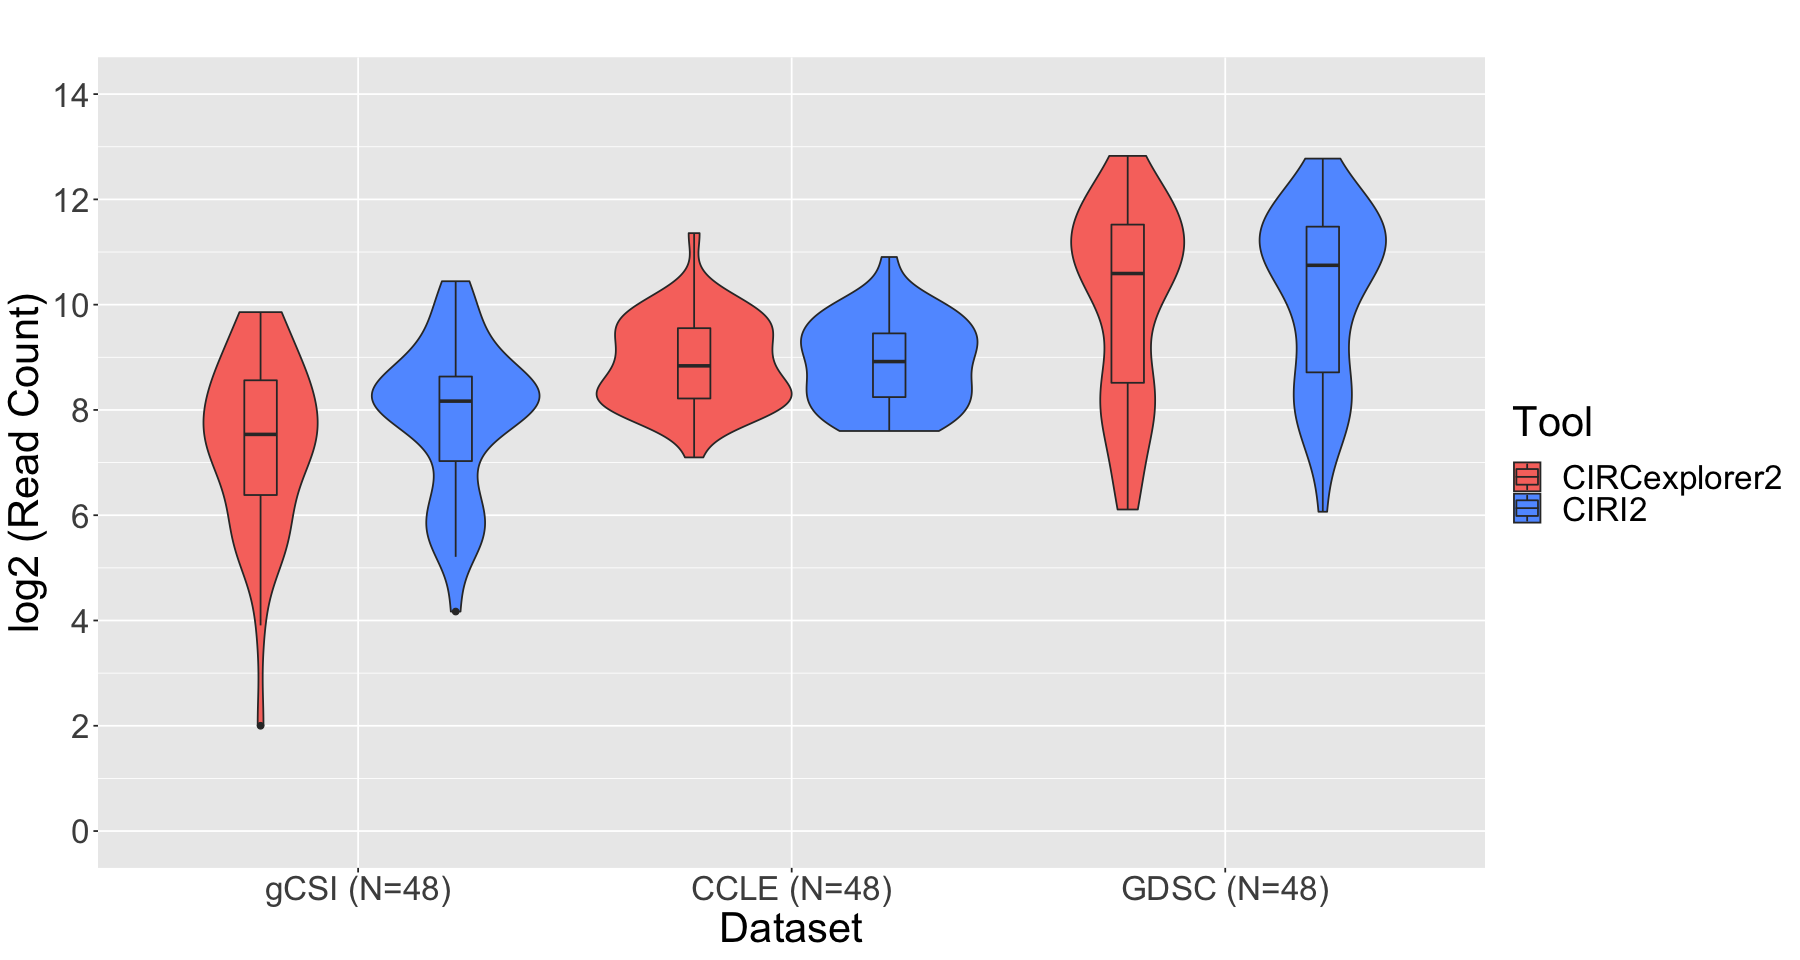

In [114]:
#organize CIRI2 and CIRCexplorer2 raw read counts for all biological replicates into combined transposed df for plotting
df.m <- reshape2::melt(log2(ciri_combined[,c("gCSI","CCLE","GDSC")]), id.vars = NULL)
df.m2 <- reshape2::melt(log2(circ_combined[,c("gCSI","CCLE","GDSC")]), id.vars = NULL)
df.m$tool <- "CIRI2"
df.m2$tool <- "CIRCexplorer2"
df.m3 <- rbind(df.m2,df.m)
#png("figures/Figure_4.png", width=400, height=300, units='mm', res = 100, pointsize=30)
options(repr.plot.width=15, repr.plot.height=8)
ggplot(df.m3, aes(x = variable, y = value, fill=tool)) + geom_violin() + labs(subtitle="",x="Dataset",y="Read count") + theme(legend.position="right", plot.title = element_text(hjust = 0.5), text = element_text(size=25)) + scale_x_discrete(
        labels=c("gCSI (N=48)", "CCLE (N=48)", "GDSC (N=48)")) + scale_y_continuous(name = "log2 (Read Count)",
                                             breaks = seq(0, 14, 2),
                                             limits=c(0, 14)) +
  geom_boxplot(width = 0.15, position = position_dodge(0.9)) + scale_fill_manual(values = c("#F8766D", "#619CFF"), name = "Tool")
       #CL-40 outlier in gCSI CIRCexplorer2/CIRI2 
#dev.off()

## <u>Overlapping circRNA's detected between CIRI2 & CIRCexplorer2</u>

In [30]:
#combined CIRI2
combined_ciri <- c(gcsi_ciri_summ$circRNA_ids, ccle_ciri_summ$circRNA_ids, gdsc_ciri_summ$circRNA_ids)

#combined CIRCexplorer2
combined_circ <- c(gcsi_circ_summ$circRNA_ids, ccle_circ_summ$circRNA_ids, gdsc_circ_summ$circRNA_ids)

(polygon[GRID.polygon.1861], polygon[GRID.polygon.1862], polygon[GRID.polygon.1863], polygon[GRID.polygon.1864], text[GRID.text.1865], text[GRID.text.1866], text[GRID.text.1867], text[GRID.text.1868], text[GRID.text.1869]) 

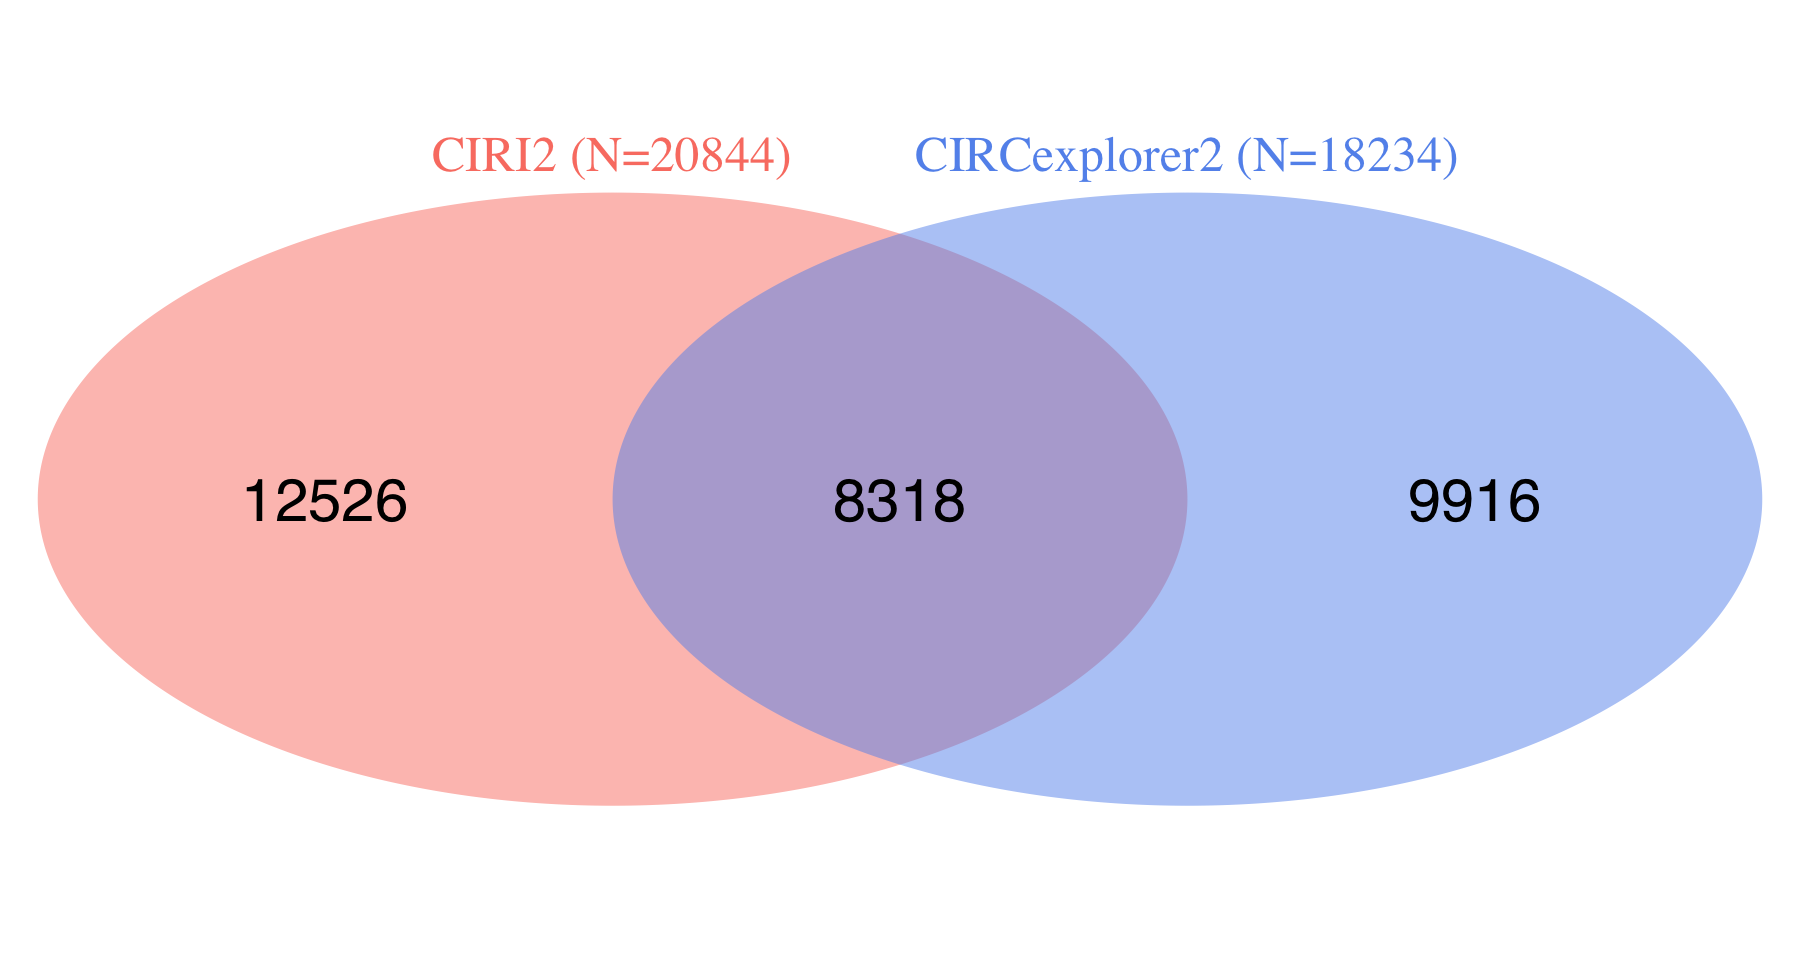

In [105]:
#plot venn-diagram of overlapping circRNA's detected  between CIRI2 and CIRCexplorer2 across all datasets
plotcolorw <- c("white", "white", "white")
gg_color_hue <- function(n) {
  hues = seq(15, 375, length=n+1)
  hcl(h=hues, l=65, c=100)[1:n]
}
ggcolors <- gg_color_hue(2)
plotcolor_venn <- ggcolors
#png("figures/Figure_1.png", width=1050, height=500, units='mm', res = 100, pointsize=30)
draw.pairwise.venn(area1= length(combined_ciri), 
                   area2=length(combined_circ), 
                   cross.area = length(which(combined_ciri %in% combined_circ)), 
                   scaled = FALSE,
                   category = c("CIRI2 (N=20844)", "CIRCexplorer2 (N=18234)"),
                   cat.pos = c(0,0),
                   lty = rep("blank", 2),
                   alpha = rep(0.5, 2),
                   # Numbers
                   cex = 3.0,
                   cat.cex  = 2.5,
                   fontfamily = "sans",
            
                   # Circles
                   lwd = 3,
                   fill = c("Salmon","Cornflower Blue"), cat.col=c("Salmon","Cornflower Blue"))
#dev.off()

## <u>Overlapping circRNA's detected between datasets</u>

In [78]:
#compare gCSI between CIRI2 & CIRCexplorer
gcsi_ciri <- gcsi_ciri_summ$circRNA_ids
gcsi_circ <- gcsi_circ_summ$circRNA_ids

#compare CCLE between CIRI2 & CIRCexplorer
ccle_ciri <- ccle_ciri_summ$circRNA_ids
ccle_circ <- ccle_circ_summ$circRNA_ids

#compare GDSC between CIRI2 & CIRCexplorer
gdsc_ciri <- gdsc_ciri_summ$circRNA_ids
gdsc_circ <- gdsc_circ_summ$circRNA_ids

### CIRI2

(polygon[GRID.polygon.1836], polygon[GRID.polygon.1837], polygon[GRID.polygon.1838], polygon[GRID.polygon.1839], polygon[GRID.polygon.1840], polygon[GRID.polygon.1841], text[GRID.text.1842], text[GRID.text.1843], text[GRID.text.1844], text[GRID.text.1845], text[GRID.text.1846], text[GRID.text.1847], text[GRID.text.1848], text[GRID.text.1849], text[GRID.text.1850], text[GRID.text.1851]) 

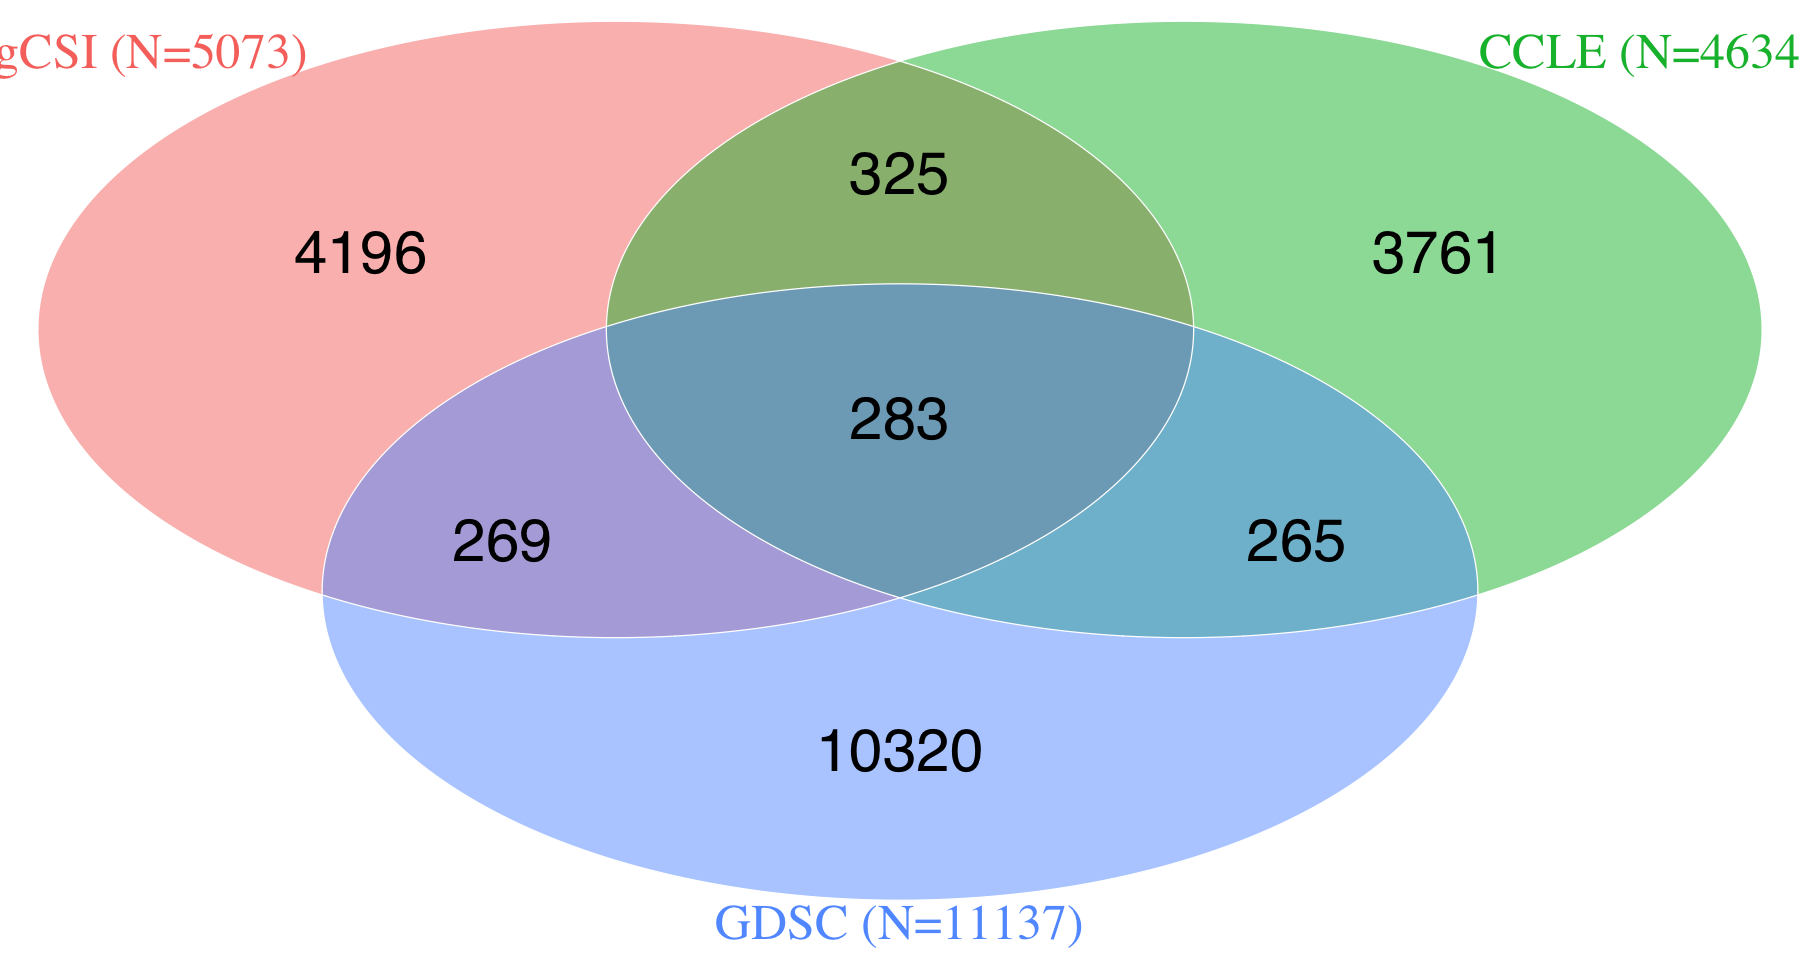

In [103]:
#plot venn-diagram of overlapping circRNA's detected  between CIRI2 and CIRCexplorer2 across all datasets
plotcolorw <- c("white", "white", "white")
gg_color_hue <- function(n) {
  hues = seq(15, 375, length=n+1)
  hcl(h=hues, l=65, c=100)[1:n]
}
ggcolors <- gg_color_hue(3)
plotcolor_venn <- ggcolors
#png("figures/Figure_2.png", width=1050, height=500, units='mm', res = 100, pointsize=30)
draw.triple.venn(area1=length(gcsi_ciri), 
                   area2=length(ccle_ciri),
                   area3=length(gdsc_ciri),
                   n12=length(Reduce(intersect, list(gcsi_ciri, ccle_ciri))),
                   n13=length(Reduce(intersect, list(gcsi_ciri, gdsc_ciri))),
                   n23=length(Reduce(intersect, list(ccle_ciri, gdsc_ciri))),
                   n123=length(Reduce(intersect, list(gcsi_ciri, ccle_ciri, gdsc_ciri))),
                   cross.area = length(Reduce(intersect, list(gcsi_ciri, ccle_ciri, gdsc_ciri))), 
                   scaled = FALSE,
                   category = c("gCSI (N=5073)", "CCLE (N=4634)", "GDSC (N=11137)"),
                   lwd = c(1,1,1),
                   fill = c("#F8766D","#00BA38","#619CFF"), cat.col = c("#F8766D","#00BA38","#619CFF"),  col = plotcolorw,
                   # Numbers
                   cex = 3.0,
                   cat.cex  = 2.5,
                   fontfamily = "sans")
#dev.off()

### CIRCexplorer2

(polygon[GRID.polygon.1820], polygon[GRID.polygon.1821], polygon[GRID.polygon.1822], polygon[GRID.polygon.1823], polygon[GRID.polygon.1824], polygon[GRID.polygon.1825], text[GRID.text.1826], text[GRID.text.1827], text[GRID.text.1828], text[GRID.text.1829], text[GRID.text.1830], text[GRID.text.1831], text[GRID.text.1832], text[GRID.text.1833], text[GRID.text.1834], text[GRID.text.1835]) 

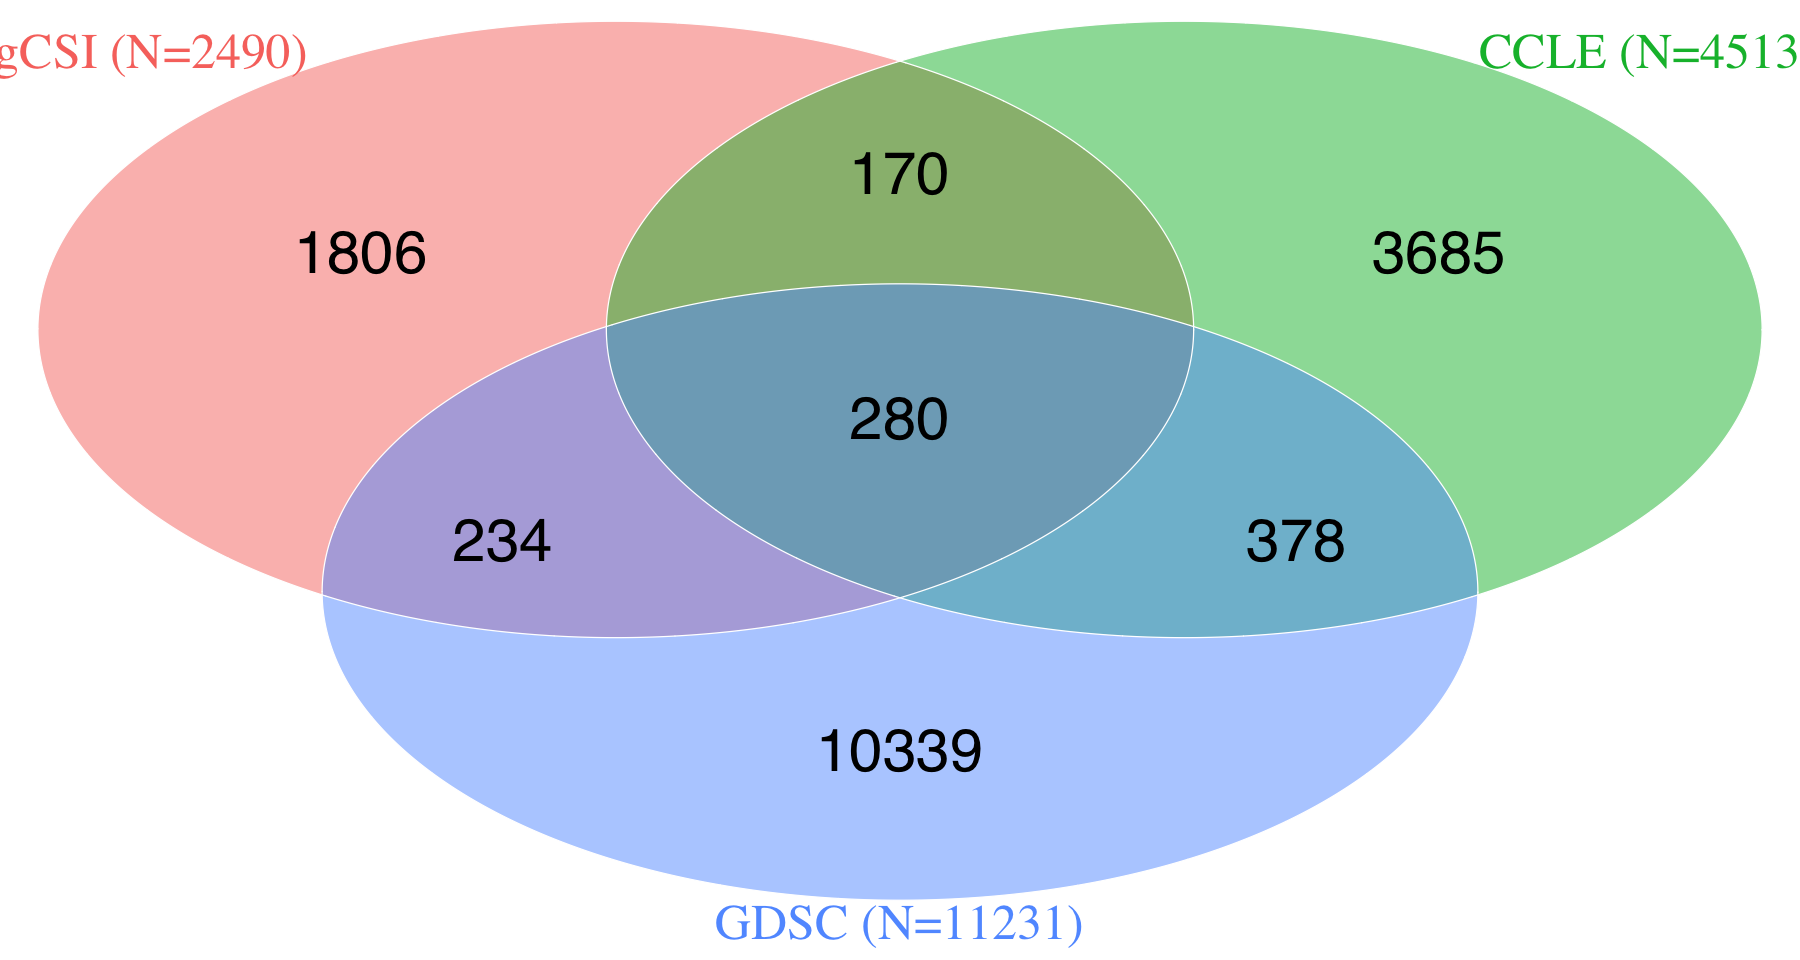

In [102]:
#plot venn-diagram of overlapping circRNA's detected  between CIRI2 and CIRCexplorer2 across all datasets
plotcolorw <- c("white", "white", "white")
gg_color_hue <- function(n) {
  hues = seq(15, 375, length=n+1)
  hcl(h=hues, l=65, c=100)[1:n]
}
ggcolors <- gg_color_hue(3)
plotcolor_venn <- ggcolors
#png("figures/Figure_3.png", width=1050, height=500, units='mm', res = 100, pointsize=30)
draw.triple.venn(area1=length(gcsi_circ), 
                   area2=length(ccle_circ),
                   area3=length(gdsc_circ),
                   n12=length(Reduce(intersect, list(gcsi_circ, ccle_circ))),
                   n13=length(Reduce(intersect, list(gcsi_circ, gdsc_circ))),
                   n23=length(Reduce(intersect, list(ccle_circ, gdsc_circ))),
                   n123=length(Reduce(intersect, list(gcsi_circ, ccle_circ, gdsc_circ))),
                   cross.area = length(Reduce(intersect, list(gcsi_circ, ccle_circ, gdsc_circ))), 
                   scaled = FALSE,
                   category = c("gCSI (N=2490)", "CCLE (N=4513)", "GDSC (N=11231)"),
                   lwd = c(1,1,1),
                   fill = c("#F8766D","#00BA38","#619CFF"), cat.col = c("#F8766D","#00BA38","#619CFF"),  col = plotcolorw,
                   # Numbers
                   cex = 3.0,
                   cat.cex  = 2.5,
                   fontfamily = "sans")
#dev.off()

## <u>circRNA expression correlation between dataset pairs</u>

In [150]:
gcsi_ccle <- qplot(as.vector(t(gcsi_ciri_matrix_norm)), y = as.vector(t(ccle_ciri_matrix_norm)), xlab = "Log2(gCSI Counts)", ylab = "Log2(CCLE Counts)") + geom_smooth(method="lm") + stat_cor(method="pearson")
gcsi_gdsc <- qplot(as.vector(t(gcsi_ciri_matrix_norm)), y = as.vector(t(gdsc_ciri_matrix_norm)), xlab = "Log2(gCSI Counts)", ylab = "Log2(GDSC Counts)") + geom_smooth(method="lm") + stat_cor(method="pearson")
#gdsc_ccle <- qplot(as.vector(t(gdsc_ciri_matrix)), y = as.vector(t(ccle_ciri_matrix)), xlab = "Log2(GDSC Counts)", ylab = "Log2(CCLE Counts)") + geom_smooth(method="lm") + stat_cor(method="pearson")
#options(repr.plot.width=10, repr.plot.height=8)
#grid.arrange(gcsi_ccle, gcsi_gdsc, gdsc_ccle)

`geom_smooth()` using formula 'y ~ x'



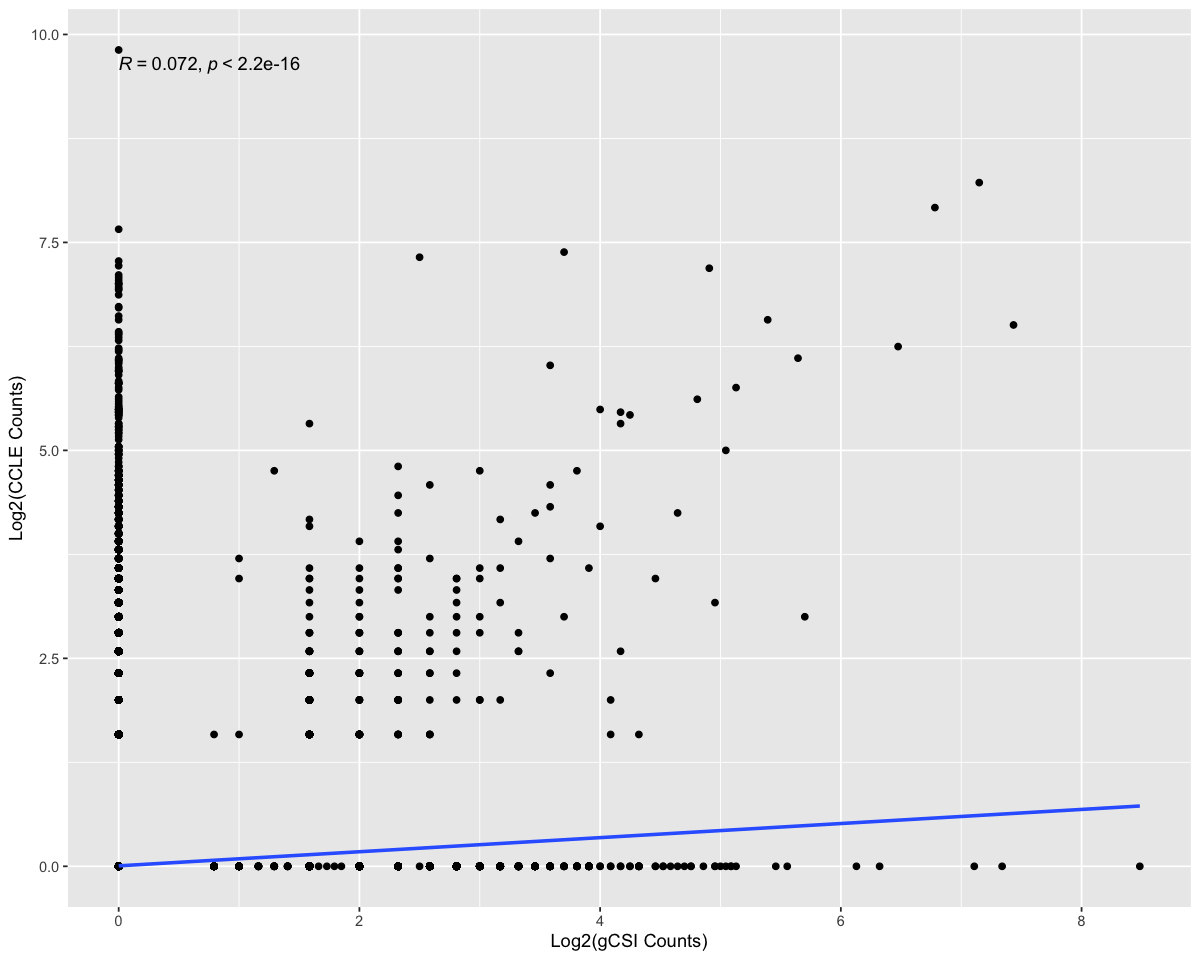

In [152]:
gcsi_ccle

## <u>Heatmap of log2 transformed read counts across biological replicates</u>

#### CIRI2

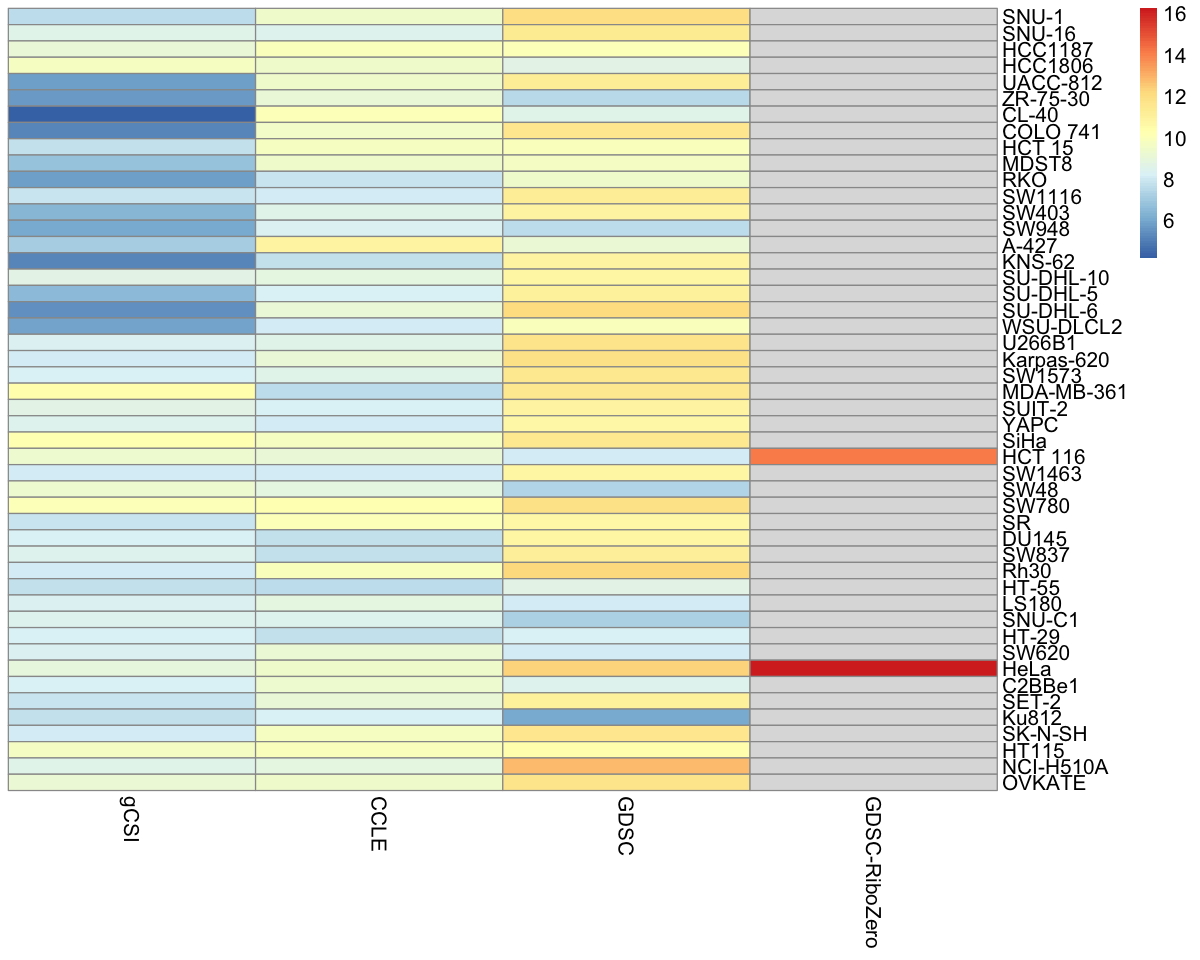

In [43]:
colnames(ciri_combined)[4] <- "GDSC-RiboZero"
options(repr.plot.width=10, repr.plot.height=8)
ciri_pheatmap <- pheatmap(log2(ciri_combined), cluster_rows=FALSE, show_rownames=TRUE,
         cluster_cols=FALSE, fontsize = 12.5)

#### CIRCexplorer2

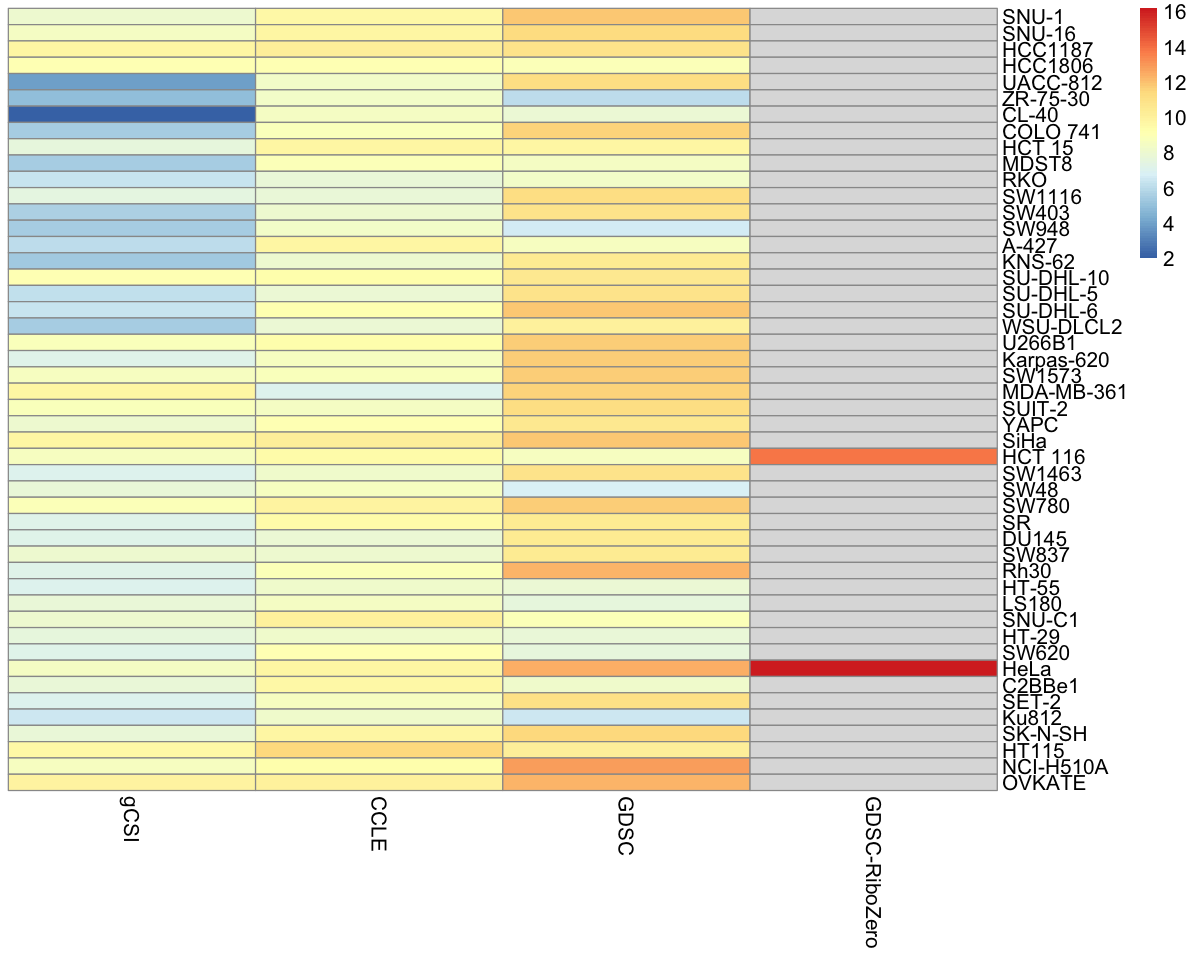

In [44]:
#heatmap of log2 read counts for CIRCexplorer2 per biological replicate across gCSI, CCLE, GDSC
colnames(circ_combined)[4] <- "GDSC-RiboZero"
options(repr.plot.width=10, repr.plot.height=8)
circ_pheatmap <- pheatmap(log2(circ_combined), cluster_rows=FALSE, show_rownames=TRUE,
         cluster_cols=FALSE, fontsize = 12.5)
#angle_col = 0

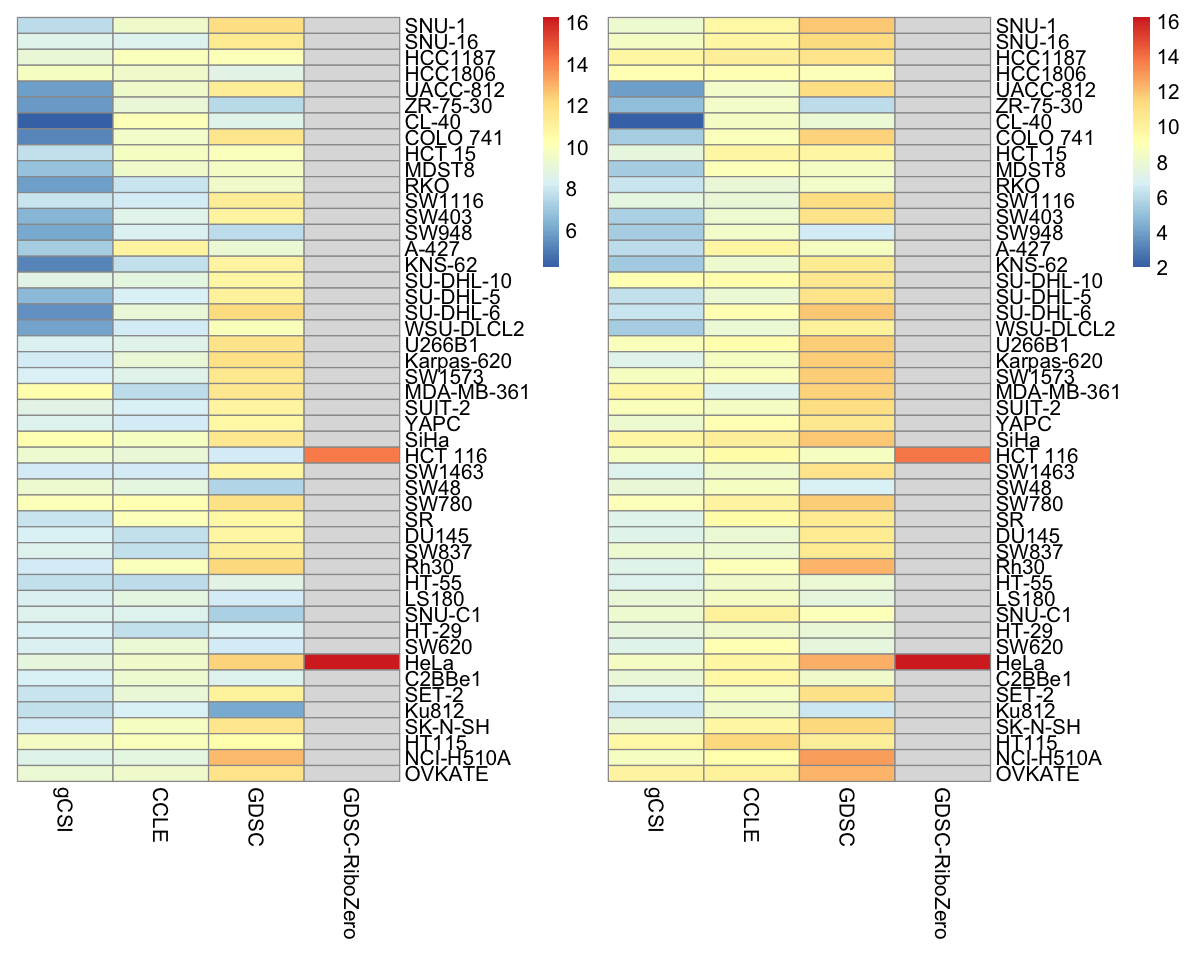

In [45]:
#combined heatmaps into one image
p1 <- as.ggplot(ciri_pheatmap)
p2 <- as.ggplot(circ_pheatmap)

# use patchwork to arrange them together
#png("figures/Figure_5.png", width=400, height=300, units='mm', res = 200, pointsize=80)
p1 + p2
#dev.off()

Using sample as id variables

Using sample as id variables



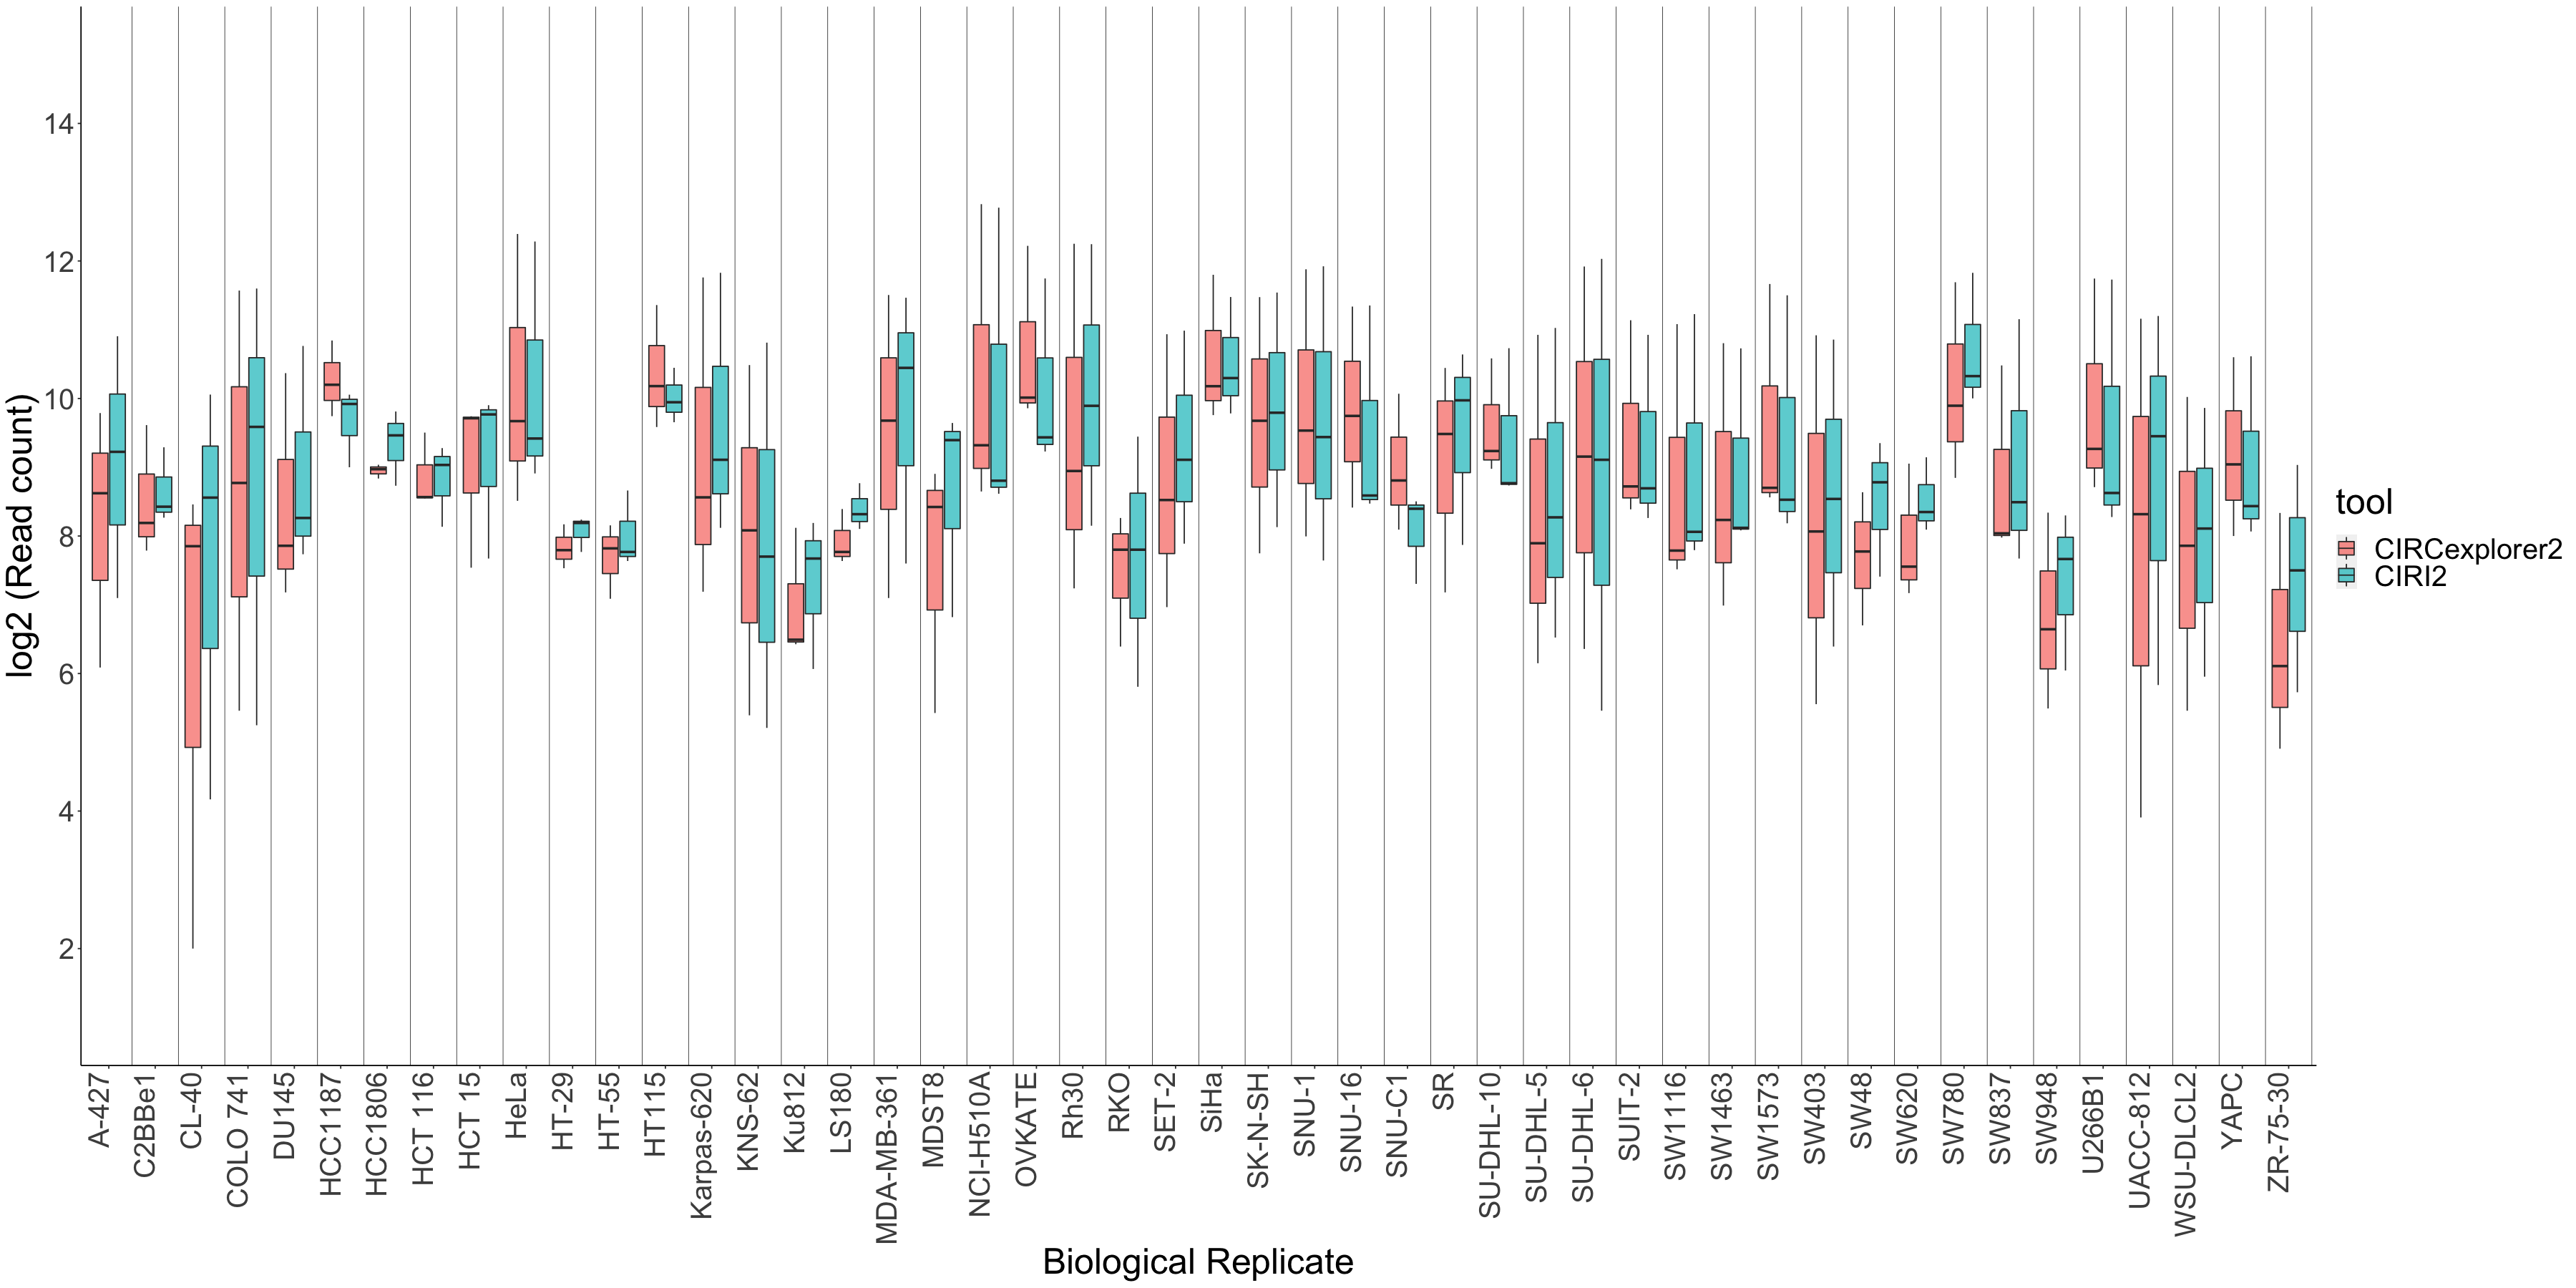

In [166]:
ciri_combined_2 <- ciri_combined[,c("gCSI","CCLE","GDSC")]
ciri_combined_2$sample <- rownames(ciri_combined_2)
ciri_combined_2 <- reshape2::melt(ciri_combined_2)
ciri_combined_2$tool <- "CIRI2"

circ_combined_2 <- circ_combined[,c("gCSI","CCLE","GDSC")]
circ_combined_2$sample <- rownames(circ_combined_2)
circ_combined_2 <- reshape2::melt(circ_combined_2)
circ_combined_2$tool <- "CIRCexplorer2"

df4 <- rbind(ciri_combined_2, circ_combined_2)
options(repr.plot.width=30, repr.plot.height=15)
ggplot(df4, aes(x = sample, y = log2(value), fill = tool)) +
  geom_boxplot(alpha=0.7) + scale_y_continuous(name = "log2 (Read count)",
                                             breaks = seq(0, 14, 2),
                                             limits=c(1, 15)) + scale_x_discrete(name = "Biological Replicate") + theme(plot.title = element_text(hjust = 0.5), text = element_text(size=30), axis.text.x = element_text(angle = 90, vjust=0, hjust=1), panel.background = element_rect(fill = 'white'), axis.line = element_line(colour = "black", size = 0.5, linetype = "solid")) + geom_vline(xintercept=seq(1.5, length(unique(df4$sample))+1 -0.5, 1), lwd=0.2, colour="black")


## <u>Validated circRNA log2 transformed counts (polyA vs Hansen RiboZero) using Hansen RNAse-R matched samples</u>

RNAse-R samples used to validate if circRNA detected in each of the cell lines using one of the tools (CIRI2/CIRCexplorer2) was a circRNA or not

In [241]:
##organize RNAse-R validated CIRI2 counts into transposed df for plotting
validated_polyA_ciri <- rbind(c("PC3", round(mean(c(as.numeric(validated_polyA_ciri$count[3]),
                                                    as.numeric(validated_polyA_ciri$count[4]))))), 
                        validated_polyA_ciri)


validated_polyA_ciri <- validated_polyA_ciri[-c(4,5),]
validated_polyA_ciri$sample <- c("PC3","22Rv1","LNCaP")
rownames(validated_polyA_ciri) <- validated_polyA_ciri$sample

validated_RiboZero_ciri$sample <-  c("22Rv1","LNCaP", "PC3")
rownames(validated_RiboZero_ciri) <- validated_RiboZero_ciri$sample
validated_RiboZero_ciri <- validated_RiboZero_ciri[rownames(validated_polyA_ciri),]

combined_ciri <- data.frame("polyA"=as.numeric(validated_polyA_ciri$count),
                            "RiboZero"=as.numeric(validated_RiboZero_ciri$count))

rownames(combined_ciri) <- validated_polyA_ciri$sample 

combined_ciri <- reshape2::melt(t(combined_ciri), id.vars = NULL)
combined_ciri$tool <- "CIRI2"
colnames(combined_ciri) <- c("method","sample","count","tool")

In [242]:
#organize RNAse-R validated CIRCexplorer2 counts into transposed df for plotting
validated_polyA_circ <- rbind(c("PC3", round(mean(c(as.numeric(validated_polyA_circ$count[3]),
                                                    as.numeric(validated_polyA_circ$count[4]))))), 
                        validated_polyA_circ)


validated_polyA_circ <- validated_polyA_circ[-c(4,5),]
validated_polyA_circ$sample <- c("PC3","22Rv1","LNCaP")
rownames(validated_polyA_circ) <-validated_polyA_circ$sample

validated_RiboZero_circ$sample <-  c("22Rv1","LNCaP", "PC3")
rownames(validated_RiboZero_circ) <- validated_RiboZero_circ$sample
validated_RiboZero_circ <- validated_RiboZero_circ[rownames(validated_polyA_circ),]

combined_circ <- data.frame("polyA"=as.numeric(validated_polyA_circ$count),
                            "RiboZero"=as.numeric(validated_RiboZero_circ$count))

rownames(combined_circ) <- validated_polyA_circ$sample 

combined_circ <- reshape2::melt(t(combined_circ), id.vars = NULL)
combined_circ$tool <- "CIRCexplorer2"
colnames(combined_circ) <- c("method","sample","count","tool")

In [243]:
combined_validated <- rbind(combined_ciri, combined_circ)

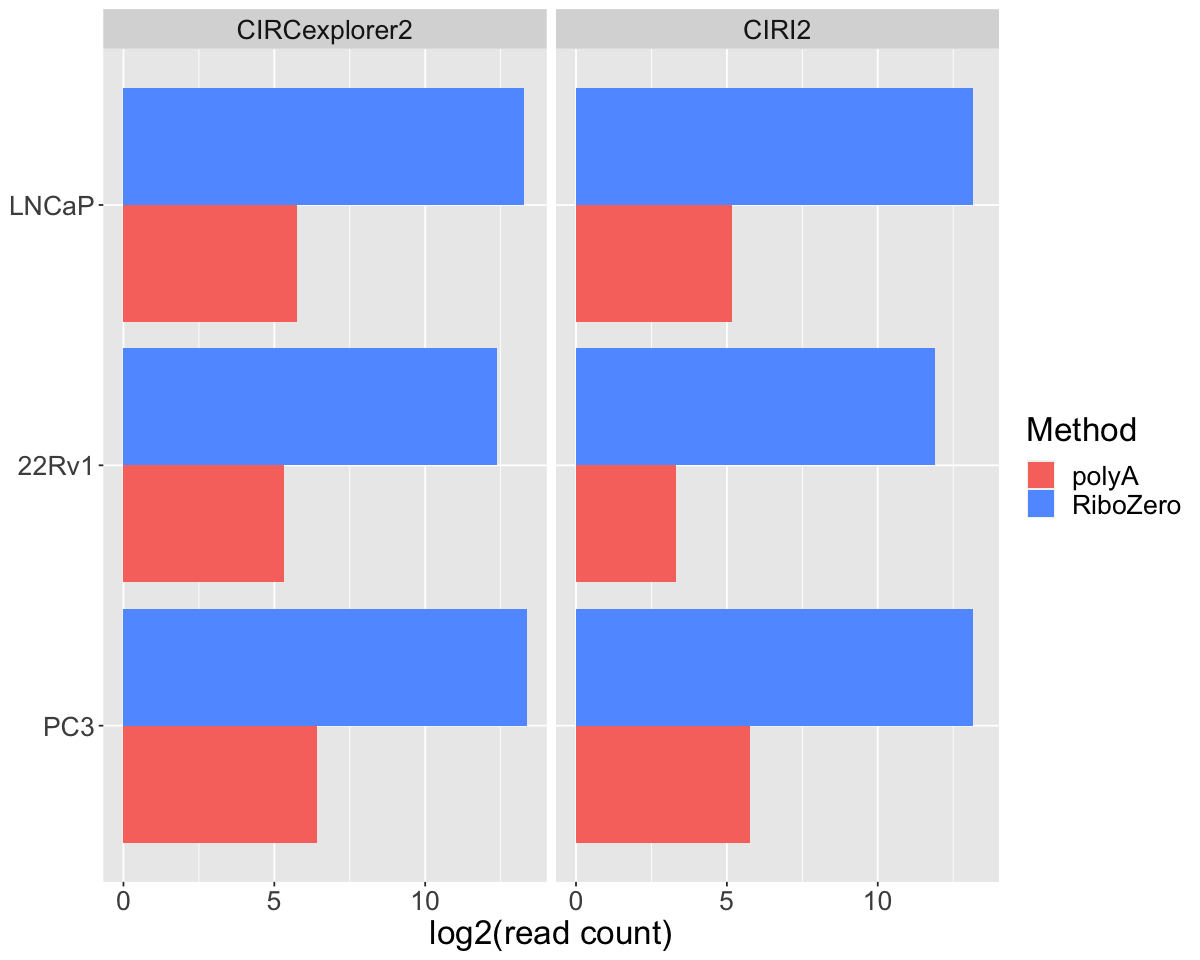

In [256]:
ggplot(combined_validated, aes(x = sample, y = log2(count), fill=method)) +
  geom_bar(stat="identity",position="dodge") +
  xlab("Cell line")+ylab("log2(read count)") + facet_wrap(~ tool) + theme(plot.title = element_text(hjust = 0.5, size=15), text = element_text(size=20), axis.title.y=element_blank()) + scale_fill_manual(values=c("#F8766D", "#619CFF"), name = "Method") + coord_flip()


## <u>circRNA log2 transformed counts (GDSC Ribo-Zero vs Poly-A Biological Replicates)</u>

In [174]:
#organize summarized CIRCexplorer2 counts with GDSC-Ribo replicates into transposed df for plotting
gdsc_ribo_circ <- circ_combined[c("HCT 116","HeLa"),]
gdsc_ribo_circ_t <- reshape2::melt(t(gdsc_ribo_circ), id.vars = NULL)
gdsc_ribo_circ_t$tool <- "CIRCexplorer2"
colnames(gdsc_ribo_circ_t) <- c("dataset","sample","count","tool")

In [175]:
#organize summarized CIRI2 counts with GDSC-Ribo replicates  into transposed df for plotting
gdsc_ribo_ciri <- ciri_combined[c("HCT 116","HeLa"),]
gdsc_ribo_ciri_t <- reshape2::melt(t(gdsc_ribo_ciri), id.vars = NULL)
gdsc_ribo_ciri_t$tool <- "CIRI2"
colnames(gdsc_ribo_ciri_t) <- c("dataset","sample","count","tool")

In [176]:
gdsc_ribo_combined <- rbind(gdsc_ribo_ciri_t, gdsc_ribo_circ_t)

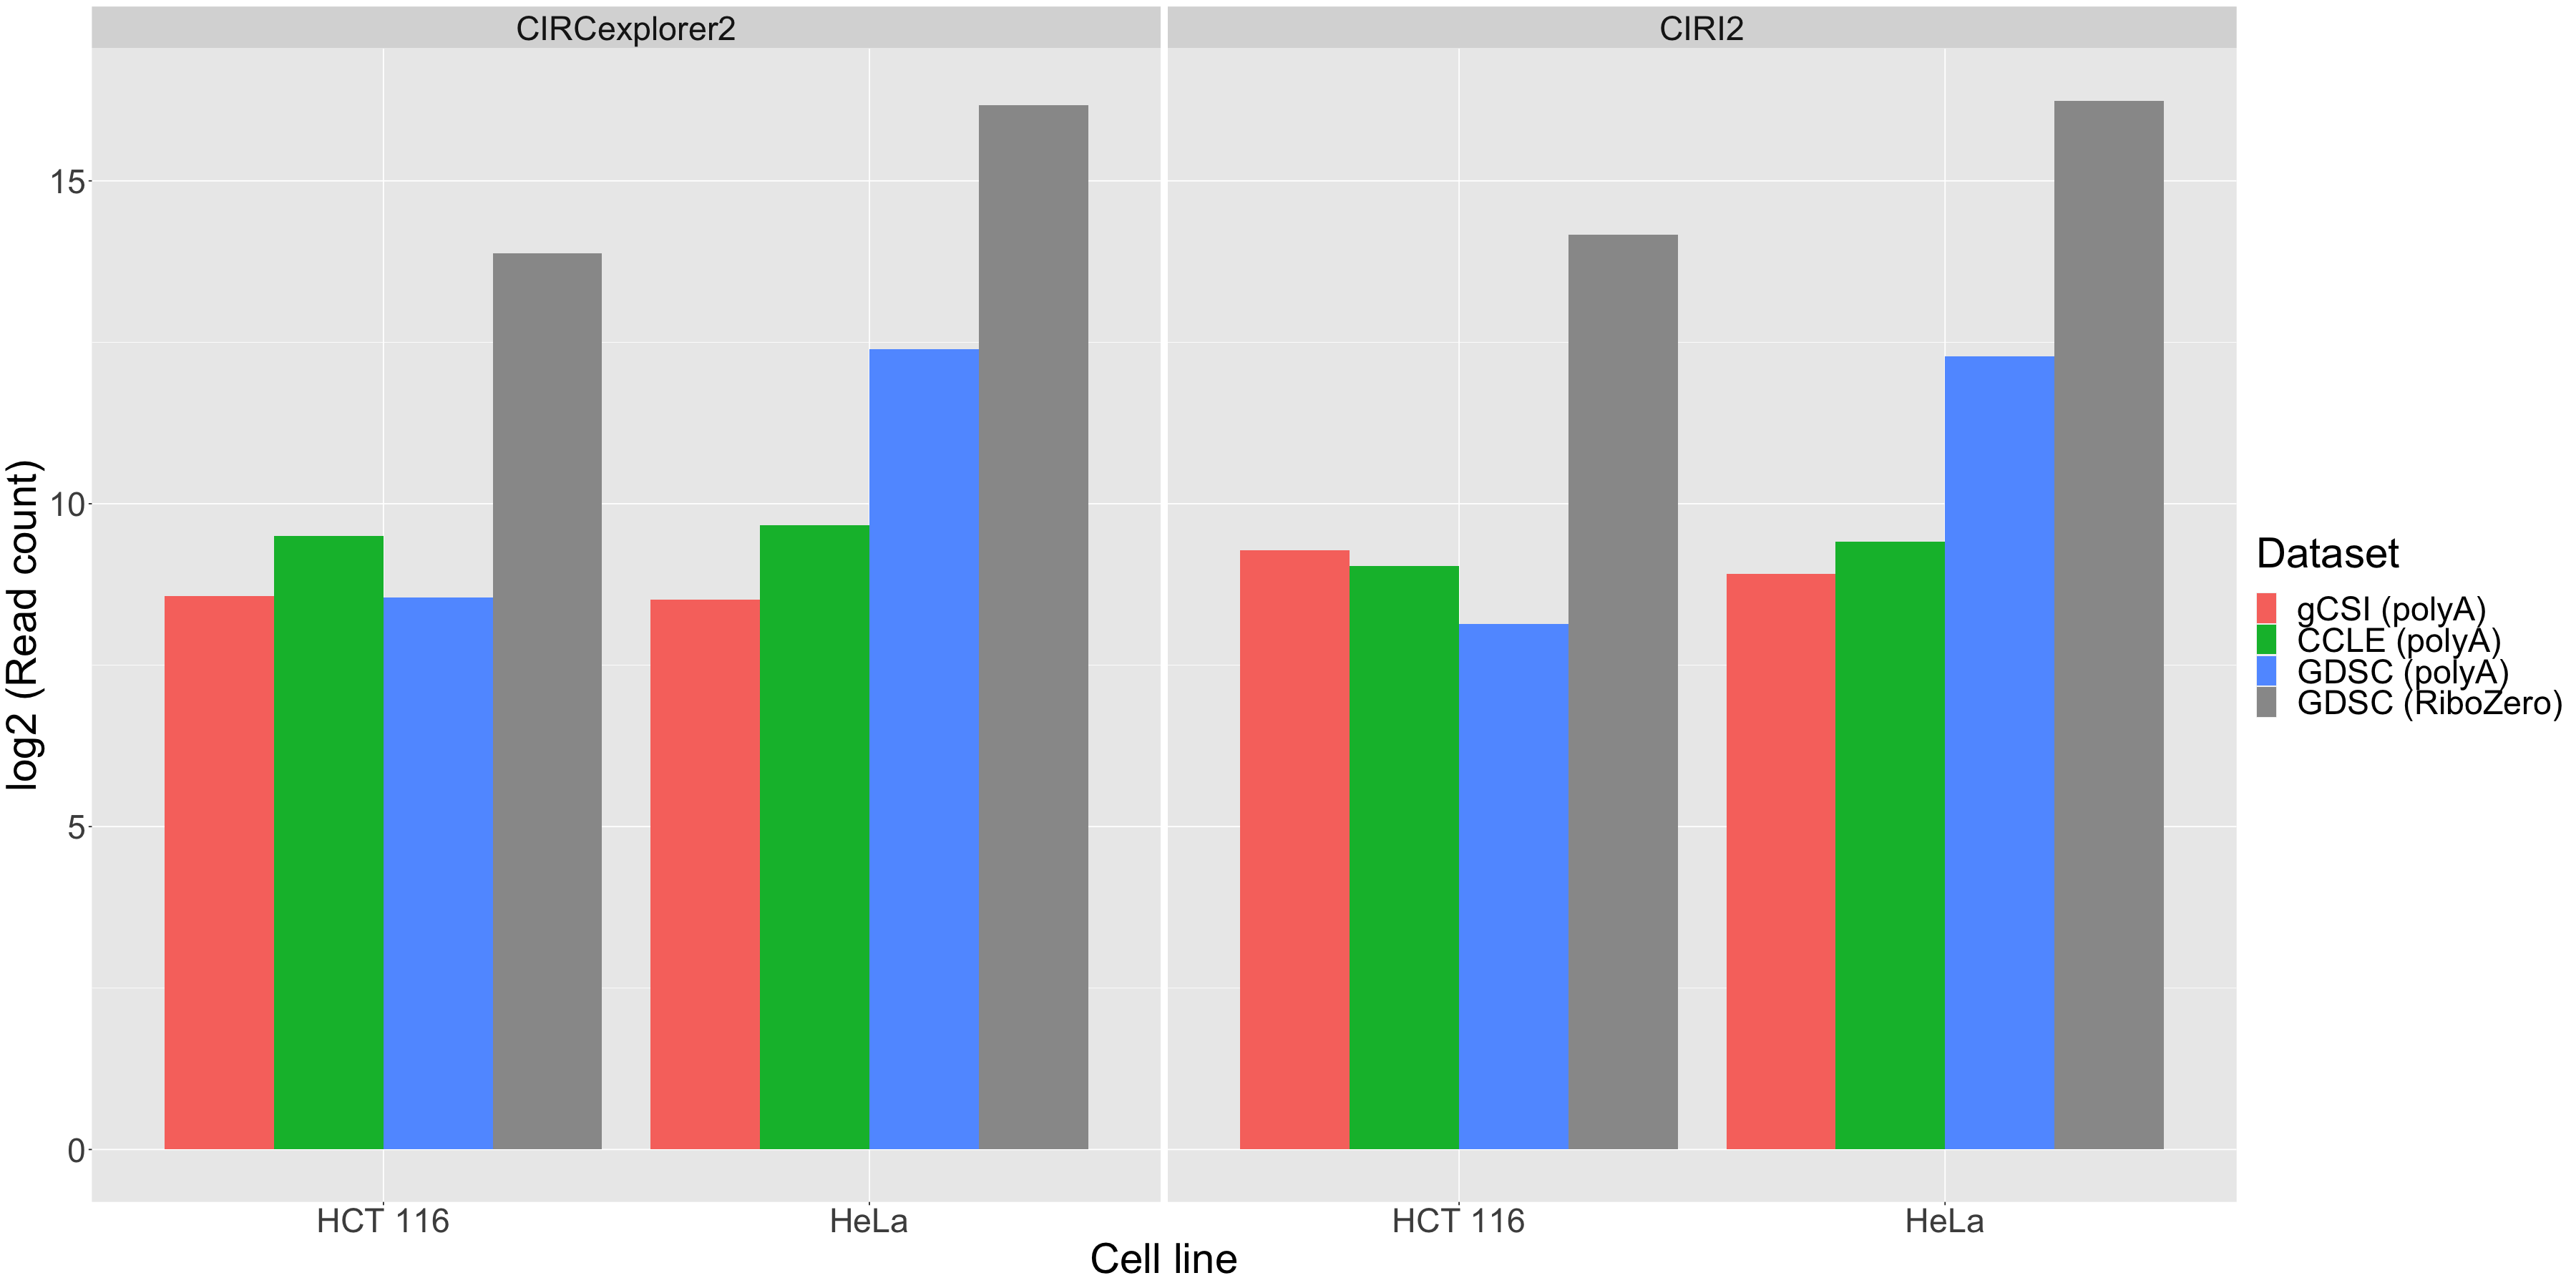

In [193]:
ggplot(gdsc_ribo_combined, aes(x = sample, y = log2(count), fill=dataset)) + scale_fill_manual(values=c("#F8766D","#00BA38","#619CFF", "#999999"), name = "Dataset", labels = c("gCSI (polyA)", "CCLE (polyA)", "GDSC (polyA)","GDSC (RiboZero)")) +
  geom_bar(stat="identity",position="dodge") +
  xlab("Cell line")+ylab("log2 (Read count)") + facet_wrap(~ tool) + theme(text = element_text(size=35))